In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define base directory
base_dir = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline"

# Folder structure
folders = [
    "data",
    "data/processed",
    "data/splits",
    "models",
    "results",
    "scripts",
    "scripts/preprocessing",
    "scripts/training",
    "scripts/inference",
    "scripts/utils",
    "notebooks"
]

# Create folders
for folder in folders:
    path = os.path.join(base_dir, folder)
    os.makedirs(path, exist_ok=True)

path


'/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/notebooks'

In [ ]:
import os
os.listdir("/content/drive/MyDrive/biovid_dual_auth/dataset/train")


['5_01_T.mp4',
 '1_03_T.mp4',
 '3_00_T.mp4',
 '3_05_T.mp4',
 '2_06_F.mp4',
 '6_00_T.mp4',
 '3_02_T.mp4',
 '3_06_T.mp4',
 '3_04_T.mp4',
 '3_17_F.mp4',
 '3_09_F.mp4',
 '1_10_F.mp4',
 '2_05_F.mp4',
 '4_03_T.mp4',
 '4_01_T.mp4',
 '4_06_F.mp4',
 '3_15_F.mp4',
 '5_10_F.mp4',
 '2_04_F.mp4',
 '5_08_F.mp4',
 '2_08_F.mp4',
 '4_00_T.mp4',
 '3_08_F.mp4',
 '2_02_T.mp4',
 '5_06_F.mp4',
 '5_05_F.mp4',
 '3_07_T.mp4',
 '3_16_F.mp4',
 '2_01_T.mp4',
 '4_02_T.mp4',
 '5_00_T.mp4',
 '4_07_F.mp4',
 '2_09_F.mp4',
 '2_10_F.mp4',
 '3_14_F.mp4',
 '4_05_F.mp4',
 '4_10_F.mp4',
 '3_11_F.mp4',
 '3_01_T.mp4',
 '1_00_T.mp4',
 '1_09_F.mp4',
 '1_06_F.mp4',
 '3_13_F.mp4',
 '4_04_F.mp4',
 '2_00_T.mp4',
 '1_05_F.mp4',
 '3_19_F.mp4',
 '5_03_T.mp4',
 '5_02_T.mp4',
 '1_02_T.mp4',
 '5_09_F.mp4',
 '1_04_F.mp4',
 '3_18_F.mp4',
 '3_20_F.mp4',
 '4_09_F.mp4',
 '2_03_T.mp4',
 '3_03_T.mp4',
 '1_08_F.mp4',
 '3_12_F.mp4',
 '3_10_F.mp4',
 '5_04_F.mp4',
 '1_01_T.mp4',
 '15_19_F.mp4',
 '9_09_F.mp4',
 '6_08_F.mp4',
 '8_01_T.mp4',
 '14_01_T

In [ ]:
!pip install opencv-python-headless librosa ffmpeg-python numpy tqdm


**Preprocessing Code**

In [ ]:
import os
import cv2
import librosa
import numpy as np
import ffmpeg
from pathlib import Path
from tqdm import tqdm

def extract_audio(video_path, output_wav, sr=16000):
    y, _ = librosa.load(video_path, sr=sr, mono=True)
    librosa.output.write_wav(output_wav, y, sr)

def extract_frames(video_path, output_npy, num_frames=30, size=(96, 96)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret: break
        if idx in frame_idxs:
            frame = cv2.resize(frame, size)
            frame = frame[..., ::-1]  # BGR to RGB
            frame = frame / 255.0  # normalize
            frames.append(frame.transpose(2, 0, 1))  # CxHxW

    cap.release()
    frames = np.stack(frames, axis=0)  # [30, 3, 96, 96]
    frames = frames.transpose(1, 0, 2, 3)  # [3, 30, 96, 96]
    np.save(output_npy, frames)

def preprocess_folder(input_folder, output_folder):
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    video_files = list(Path(input_folder).rglob("*.mp4"))

    for video_path in tqdm(video_files):
        uid = video_path.stem
        out_video_dir = Path(output_folder) / uid
        out_video_dir.mkdir(exist_ok=True, parents=True)

        frames_path = out_video_dir / "frames.npy"
        audio_path = out_video_dir / "audio.wav"

        try:
            extract_frames(str(video_path), str(frames_path))
            extract_audio(str(video_path), str(audio_path))
        except Exception as e:
            print(f"Error with {video_path}: {e}")


These Paths in Colab Before Running Preprocessing

In [ ]:
train_input = "/content/drive/MyDrive/biovid_dual_auth/dataset/train"
test_input = "/content/drive/MyDrive/biovid_dual_auth/dataset/test-set"

train_output = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train"
test_output  = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/test"

preprocess_folder(train_input, train_output)
preprocess_folder(test_input, test_output)


  0%|          | 0/457 [00:00<?, ?it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/457 [00:17<2:09:35, 17.05s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 2/457 [00:18<1:01:14,  8.08s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 3/457 [00:20<39:04,  5.16s/it]  

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 4/457 [00:22<28:41,  3.80s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 5/457 [00:24<25:38,  3.40s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|▏         | 6/457 [00:26<20:35,  2.74s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 7/457 [00:27<16:49,  2.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 8/457 [00:28<14:14,  1.90s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 9/457 [00:30<12:45,  1.71s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 10/457 [00:31<11:45,  1.58s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 11/457 [00:32<11:03,  1.49s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 12/457 [00:33<10:38,  1.43s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 13/457 [00:35<10:24,  1.41s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 14/457 [00:36<10:07,  1.37s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 15/457 [00:37<09:41,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 16/457 [00:39<09:33,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 17/457 [00:40<09:35,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 18/457 [00:41<09:35,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 19/457 [00:42<09:19,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 20/457 [00:44<09:16,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 21/457 [00:45<09:06,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 22/457 [00:46<09:04,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 23/457 [00:47<09:00,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 24/457 [00:49<08:54,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 25/457 [00:50<08:41,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 26/457 [00:51<08:41,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 27/457 [00:52<08:46,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 28/457 [00:53<08:53,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▋         | 29/457 [00:55<09:13,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 30/457 [00:56<09:12,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 31/457 [00:58<09:24,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 32/457 [00:59<09:12,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 33/457 [01:00<08:56,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 34/457 [01:01<08:56,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 35/457 [01:02<08:44,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 36/457 [01:04<08:45,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 37/457 [01:05<08:44,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 38/457 [01:06<08:39,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▊         | 39/457 [01:07<08:41,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 40/457 [01:09<08:40,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 41/457 [01:10<08:47,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 42/457 [01:11<08:46,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 43/457 [01:13<08:42,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 44/457 [01:14<08:31,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 45/457 [01:15<08:51,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 46/457 [01:16<08:39,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 47/457 [01:17<08:26,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 48/457 [01:19<08:54,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 49/457 [01:20<09:18,  1.37s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 50/457 [01:22<08:57,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 51/457 [01:23<08:57,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█▏        | 52/457 [01:24<08:58,  1.33s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 53/457 [01:26<08:40,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 54/457 [01:27<08:37,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 55/457 [01:28<08:29,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 56/457 [01:29<08:34,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 57/457 [01:31<08:16,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 58/457 [01:32<08:07,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 59/457 [01:33<08:25,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 60/457 [01:34<08:27,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 61/457 [01:35<07:52,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▎        | 62/457 [01:37<08:16,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 63/457 [01:38<08:13,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 64/457 [01:39<08:00,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 65/457 [01:40<08:04,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 66/457 [01:42<07:56,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 67/457 [01:43<08:01,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 68/457 [01:44<07:55,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 69/457 [01:45<08:08,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 70/457 [01:47<08:05,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 71/457 [01:48<08:09,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 72/457 [01:50<09:09,  1.43s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 73/457 [01:51<08:36,  1.34s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 74/457 [01:52<08:18,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▋        | 75/457 [01:53<08:04,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 76/457 [01:54<07:47,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 77/457 [01:56<07:59,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 78/457 [01:57<07:51,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 79/457 [01:58<07:50,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 80/457 [01:59<07:45,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 81/457 [02:01<07:39,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 82/457 [02:02<07:40,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 83/457 [02:03<07:41,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 84/457 [02:04<07:45,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▊        | 85/457 [02:06<07:37,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 86/457 [02:07<07:31,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 87/457 [02:08<07:32,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 88/457 [02:09<07:28,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 89/457 [02:10<07:23,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 90/457 [02:12<07:39,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 91/457 [02:13<07:29,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 92/457 [02:14<07:26,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 93/457 [02:15<07:24,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 94/457 [02:17<07:21,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 95/457 [02:18<07:27,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 96/457 [02:19<07:19,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 97/457 [02:20<07:19,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██▏       | 98/457 [02:22<07:35,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 99/457 [02:23<07:24,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 100/457 [02:24<07:43,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 101/457 [02:25<07:28,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 102/457 [02:27<07:28,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 103/457 [02:28<07:23,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 104/457 [02:29<07:20,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 105/457 [02:31<07:39,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 106/457 [02:32<07:30,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 107/457 [02:33<07:20,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▎       | 108/457 [02:34<07:16,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 109/457 [02:35<07:04,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 110/457 [02:37<07:03,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 111/457 [02:38<07:31,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 112/457 [02:39<07:13,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 113/457 [02:40<07:04,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 114/457 [02:42<07:17,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 115/457 [02:43<07:30,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 116/457 [02:44<07:24,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 117/457 [02:46<07:30,  1.33s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 118/457 [02:47<07:21,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 119/457 [02:48<07:15,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 120/457 [02:50<07:23,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 121/457 [02:51<07:22,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 122/457 [02:52<06:58,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 123/457 [02:53<06:53,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 124/457 [02:55<06:46,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 125/457 [02:56<06:45,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 126/457 [02:57<06:36,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 127/457 [02:58<06:49,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 128/457 [03:00<06:54,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 129/457 [03:01<06:48,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 130/457 [03:02<06:50,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▊       | 131/457 [03:03<06:39,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 132/457 [03:04<06:35,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 133/457 [03:06<06:39,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 134/457 [03:07<06:38,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 135/457 [03:08<06:28,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 136/457 [03:09<06:26,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 137/457 [03:10<06:18,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 138/457 [03:12<06:32,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 139/457 [03:13<06:43,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 140/457 [03:14<06:45,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 141/457 [03:16<07:15,  1.38s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 142/457 [03:17<06:54,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███▏      | 143/457 [03:18<06:39,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 144/457 [03:20<06:33,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 145/457 [03:21<06:24,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 146/457 [03:22<06:22,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 147/457 [03:23<06:19,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 148/457 [03:24<06:15,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 149/457 [03:26<06:19,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 150/457 [03:27<06:18,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 151/457 [03:28<06:18,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 152/457 [03:29<06:17,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 153/457 [03:31<06:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▎      | 154/457 [03:32<06:11,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 155/457 [03:33<06:16,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 156/457 [03:34<06:24,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 157/457 [03:36<06:18,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 158/457 [03:37<06:28,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 159/457 [03:38<06:25,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 160/457 [03:40<06:20,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 161/457 [03:41<06:14,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 162/457 [03:42<06:32,  1.33s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 163/457 [03:44<06:27,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 164/457 [03:45<06:18,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 165/457 [03:46<06:06,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▋      | 166/457 [03:47<05:58,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 167/457 [03:49<06:08,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 168/457 [03:50<06:10,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 169/457 [03:51<06:17,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 170/457 [03:52<06:08,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 171/457 [03:54<05:55,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 172/457 [03:55<05:44,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 173/457 [03:56<05:50,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 174/457 [03:57<05:44,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 175/457 [03:58<05:46,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▊      | 176/457 [04:00<05:49,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▊      | 177/457 [04:01<05:45,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 178/457 [04:02<05:51,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 179/457 [04:04<05:52,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 180/457 [04:05<05:45,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 181/457 [04:06<05:34,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 182/457 [04:07<05:32,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 183/457 [04:08<05:28,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 184/457 [04:10<05:34,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 185/457 [04:11<05:30,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 186/457 [04:12<05:28,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 187/457 [04:13<05:28,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 188/457 [04:14<05:24,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████▏     | 189/457 [04:16<05:26,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 190/457 [04:17<05:28,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 191/457 [04:18<05:28,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 192/457 [04:19<05:28,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 193/457 [04:20<05:21,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 194/457 [04:22<05:15,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 195/457 [04:23<05:12,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 196/457 [04:24<05:09,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 197/457 [04:25<05:10,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 198/457 [04:27<05:17,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▎     | 199/457 [04:28<05:17,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 200/457 [04:29<05:11,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 201/457 [04:30<05:18,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 202/457 [04:32<05:33,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 203/457 [04:33<05:25,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 204/457 [04:34<05:27,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 205/457 [04:36<05:25,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 206/457 [04:37<05:20,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 207/457 [04:38<05:22,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 208/457 [04:39<05:17,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 209/457 [04:41<05:22,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 210/457 [04:42<05:10,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 211/457 [04:43<05:05,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▋     | 212/457 [04:44<05:02,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 213/457 [04:46<05:04,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 214/457 [04:47<05:02,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 215/457 [04:48<05:02,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 216/457 [04:49<04:57,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 217/457 [04:51<05:06,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 218/457 [04:52<05:03,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 219/457 [04:53<05:03,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 220/457 [04:54<05:03,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 221/457 [04:56<04:58,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▊     | 222/457 [04:57<04:59,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 223/457 [04:58<04:52,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 224/457 [04:59<04:50,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 225/457 [05:01<04:49,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 226/457 [05:02<05:02,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 227/457 [05:03<04:55,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 228/457 [05:05<04:57,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 229/457 [05:06<05:26,  1.43s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 230/457 [05:08<05:17,  1.40s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 231/457 [05:09<05:03,  1.34s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 232/457 [05:10<04:49,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 233/457 [05:11<04:40,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 234/457 [05:12<04:34,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████▏    | 235/457 [05:14<04:44,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 236/457 [05:15<04:48,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 237/457 [05:16<04:39,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 238/457 [05:18<04:35,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 239/457 [05:19<04:30,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 240/457 [05:20<04:36,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 241/457 [05:22<04:37,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 242/457 [05:23<04:31,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 243/457 [05:24<04:30,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 244/457 [05:25<04:24,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▎    | 245/457 [05:26<04:27,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 246/457 [05:28<04:24,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 247/457 [05:29<04:26,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 248/457 [05:30<04:21,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 249/457 [05:31<04:15,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 250/457 [05:33<04:16,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 251/457 [05:34<04:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 252/457 [05:35<04:09,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 253/457 [05:36<04:08,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 254/457 [05:38<04:12,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 255/457 [05:39<04:07,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 256/457 [05:40<04:03,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 257/457 [05:41<04:01,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▋    | 258/457 [05:42<04:02,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 259/457 [05:44<03:57,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 260/457 [05:45<03:59,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 261/457 [05:46<04:02,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 262/457 [05:47<04:00,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 263/457 [05:49<04:00,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 264/457 [05:50<04:08,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 265/457 [05:51<04:06,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 266/457 [05:52<03:59,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 267/457 [05:54<03:55,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▊    | 268/457 [05:55<03:50,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 269/457 [05:56<03:48,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 270/457 [05:57<03:50,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 271/457 [05:58<03:46,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 272/457 [06:00<03:42,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 273/457 [06:01<03:37,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 274/457 [06:02<03:42,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 275/457 [06:03<03:43,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 276/457 [06:05<03:45,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 277/457 [06:06<03:42,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 278/457 [06:07<03:36,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 279/457 [06:08<03:36,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████▏   | 280/457 [06:09<03:34,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████▏   | 281/457 [06:11<03:33,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 282/457 [06:12<03:31,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 283/457 [06:13<03:31,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 284/457 [06:14<03:31,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 285/457 [06:16<03:31,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 286/457 [06:17<03:27,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 287/457 [06:18<03:24,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 288/457 [06:19<03:23,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 289/457 [06:20<03:25,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 290/457 [06:22<03:22,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▎   | 291/457 [06:23<03:22,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 292/457 [06:24<03:07,  1.13s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 293/457 [06:25<03:12,  1.17s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 294/457 [06:27<03:39,  1.34s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 295/457 [06:28<03:31,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 296/457 [06:29<03:26,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 297/457 [06:30<03:26,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 298/457 [06:32<03:20,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 299/457 [06:33<03:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 300/457 [06:34<03:16,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 301/457 [06:35<03:14,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 302/457 [06:36<03:07,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▋   | 303/457 [06:38<03:03,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 304/457 [06:39<03:06,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 305/457 [06:40<03:08,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 306/457 [06:41<03:07,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 307/457 [06:43<03:14,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 308/457 [06:44<03:07,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 309/457 [06:45<03:05,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 310/457 [06:46<03:01,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 311/457 [06:48<03:08,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 312/457 [06:49<03:03,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 313/457 [06:51<03:08,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▊   | 314/457 [06:52<03:15,  1.37s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 315/457 [06:53<03:09,  1.33s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 316/457 [06:55<03:11,  1.36s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 317/457 [06:56<03:08,  1.35s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 318/457 [06:57<03:07,  1.35s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 319/457 [06:58<02:52,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 320/457 [07:00<02:49,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 321/457 [07:01<02:44,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 322/457 [07:02<02:50,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 323/457 [07:03<02:48,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 324/457 [07:05<02:47,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 325/457 [07:06<02:38,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████▏  | 326/457 [07:07<02:41,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 327/457 [07:08<02:39,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 328/457 [07:10<02:40,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 329/457 [07:11<02:39,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 330/457 [07:12<02:38,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 331/457 [07:13<02:36,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 332/457 [07:15<02:37,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 333/457 [07:16<02:32,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 334/457 [07:17<02:30,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 335/457 [07:18<02:31,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 336/457 [07:19<02:32,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 337/457 [07:21<02:33,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 338/457 [07:22<02:29,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 339/457 [07:23<02:25,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 340/457 [07:25<02:27,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 341/457 [07:26<02:27,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 342/457 [07:27<02:23,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 343/457 [07:28<02:20,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 344/457 [07:29<02:20,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 345/457 [07:31<02:21,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 346/457 [07:32<02:22,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 347/457 [07:33<02:17,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 348/457 [07:34<02:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▋  | 349/457 [07:36<02:11,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 350/457 [07:37<02:14,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 351/457 [07:38<02:10,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 352/457 [07:39<02:11,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 353/457 [07:41<02:09,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 354/457 [07:42<02:10,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 355/457 [07:43<02:07,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 356/457 [07:44<02:06,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 357/457 [07:46<02:03,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 358/457 [07:47<02:00,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▊  | 359/457 [07:48<01:57,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 360/457 [07:49<02:02,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 361/457 [07:51<01:56,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 362/457 [07:52<01:56,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 363/457 [07:53<01:53,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 364/457 [07:54<01:52,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 365/457 [07:55<01:52,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 366/457 [07:57<01:51,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 367/457 [07:58<01:46,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 368/457 [07:59<01:47,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 369/457 [08:00<01:51,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 370/457 [08:02<01:49,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 371/457 [08:03<01:46,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████▏ | 372/457 [08:04<01:46,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 373/457 [08:05<01:44,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 374/457 [08:07<01:43,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 375/457 [08:08<01:42,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 376/457 [08:09<01:40,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 377/457 [08:10<01:39,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 378/457 [08:11<01:35,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 379/457 [08:13<01:35,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 380/457 [08:14<01:33,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 381/457 [08:15<01:33,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▎ | 382/457 [08:16<01:32,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 383/457 [08:18<01:30,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 384/457 [08:19<01:28,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 385/457 [08:20<01:27,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 386/457 [08:21<01:25,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 387/457 [08:22<01:24,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 388/457 [08:24<01:27,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 389/457 [08:25<01:27,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 390/457 [08:26<01:23,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 391/457 [08:27<01:21,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 392/457 [08:29<01:21,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 393/457 [08:30<01:18,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 394/457 [08:31<01:16,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▋ | 395/457 [08:32<01:16,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 396/457 [08:34<01:15,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 397/457 [08:35<01:13,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 398/457 [08:36<01:11,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 399/457 [08:37<01:09,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 400/457 [08:38<01:06,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 401/457 [08:40<01:06,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 402/457 [08:41<01:06,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 403/457 [08:42<01:04,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 404/457 [08:43<01:03,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▊ | 405/457 [08:44<01:02,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 406/457 [08:46<01:03,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 407/457 [08:47<01:00,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 408/457 [08:48<01:00,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 409/457 [08:49<00:59,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 410/457 [08:51<00:58,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 411/457 [08:52<00:56,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 412/457 [08:53<00:55,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 413/457 [08:54<00:54,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 414/457 [08:56<00:52,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 415/457 [08:57<00:49,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 416/457 [08:58<00:48,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 417/457 [08:59<00:47,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████▏| 418/457 [09:00<00:46,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 419/457 [09:01<00:44,  1.17s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 420/457 [09:03<00:44,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 421/457 [09:04<00:43,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 422/457 [09:05<00:42,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 423/457 [09:06<00:40,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 424/457 [09:07<00:38,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 425/457 [09:09<00:38,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 426/457 [09:10<00:38,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 427/457 [09:11<00:36,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▎| 428/457 [09:12<00:35,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 429/457 [09:13<00:33,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 430/457 [09:15<00:32,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 431/457 [09:16<00:32,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 432/457 [09:17<00:31,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 433/457 [09:18<00:29,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 434/457 [09:19<00:27,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 435/457 [09:21<00:26,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 436/457 [09:22<00:25,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 437/457 [09:23<00:24,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 438/457 [09:24<00:23,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 439/457 [09:26<00:21,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 440/457 [09:27<00:20,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 441/457 [09:28<00:19,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 442/457 [09:29<00:18,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 443/457 [09:30<00:17,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 444/457 [09:32<00:15,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 445/457 [09:33<00:15,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 446/457 [09:34<00:14,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 447/457 [09:36<00:12,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 448/457 [09:37<00:11,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 449/457 [09:38<00:09,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 450/457 [09:39<00:08,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▊| 451/457 [09:41<00:07,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 452/457 [09:42<00:06,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 453/457 [09:43<00:05,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 454/457 [09:44<00:03,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|█████████▉| 455/457 [09:45<00:02,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|█████████▉| 456/457 [09:47<00:01,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 457/457 [09:48<00:00,  1.29s/it]


Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_09_F.mp4: No librosa attribute output


  0%|          | 0/193 [00:00<?, ?it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 1/193 [00:01<05:41,  1.78s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/54b3c55a8c9a5a2ef6b963bc3dea2cf829d6856d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 2/193 [00:03<06:01,  1.90s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/17afa821da958310b2a67000aad795210f927df3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 3/193 [00:04<05:02,  1.59s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8e8965e4bd598b30fdbf98562f9febdc0f79aa82.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 4/193 [00:06<04:36,  1.46s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1afb07736d58c8b2d9f25198edf5592e5cfdffb7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 5/193 [00:07<04:18,  1.37s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6f282c3f1f95fdd0c4f4d4bdd5a6403b722990af.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 6/193 [00:08<04:05,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/84ea630c4d99acbb17c752c830e89bc02e2b4d8d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 7/193 [00:09<03:55,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/74c422402755812968acd75685c88b599e51eeca.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 8/193 [00:11<03:55,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7c942d514749e9e0be5dcf2219657dadfddb1078.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 9/193 [00:12<04:04,  1.33s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/087afdd82862f967a8cc79e84aee9a79dd5b06ce.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 10/193 [00:13<03:55,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1c3ebfc6511745221971f180f51ac3dc5ae977ea.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 11/193 [00:14<03:50,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7b38f307d2381ebd139114901e9fe8de1faffb42.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 12/193 [00:16<03:41,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/43c58f36e0ad4d4eff97fd639631c0c918874bc5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 13/193 [00:17<03:43,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/54eee17ca03bc6f2b5bb922d9b633555f0d781e4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 14/193 [00:18<03:42,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/86c116d392d0687abf614cbaef625c0049a5c852.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 15/193 [00:19<03:46,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6dcc7d6a8fd8b59eadcdc97523b164c02f018f3b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 16/193 [00:21<03:48,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/55a1bc5c49c93dbe030a5c280be4a01524d5ebb0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 17/193 [00:22<03:39,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5ee659bec764689faabf0ceaa685a2585c7e1953.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 18/193 [00:23<03:38,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8af50b7d959f96019011e1f5936d98a14128bd02.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 19/193 [00:24<03:35,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0d3b47537c9ef35823a51a9869298b1d4efa1baa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 20/193 [00:26<03:35,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4be6f6e13ad663b65afc016c7eed0aa6aee7b9a8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 21/193 [00:27<03:30,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6f87adad3adf4649ada71d27e59c781660914b03.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█▏        | 22/193 [00:28<03:14,  1.14s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/227b82f518c2b7ddf17fc54d6e14a46f7b5f7f0e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 23/193 [00:29<03:22,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3c1d43bf026ce50027a6d9f19205575af4a4bf26.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 24/193 [00:31<03:31,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0025d92127245cfbb312dfabae3f231c92e0ee5b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 25/193 [00:32<03:26,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/98c9f85d919e9f81c788203d9a161b5dfaa15728.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 26/193 [00:33<03:23,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6c520333e583d7176778377c7ac848dc5cf11686.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 27/193 [00:34<03:26,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/56ab6f5cde02e22ba850cbdd7b58f3d2d91f09dd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 28/193 [00:35<03:20,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1c83e5c1c5eb621a439d84680d960e7e3de60186.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 29/193 [00:37<03:21,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/94aea0e1246e5c8d50f7e91db5583b9a2c9b32b4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 30/193 [00:38<03:14,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4ce33ef88045fd02918df9764a7ac3b31130b015.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 31/193 [00:39<03:21,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/68c6d381911a281e2c6e6b4afbdaf3dc739e0ae2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 32/193 [00:40<03:18,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/21f6b59a3d988163eac769688d45d175358a8b16.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 33/193 [00:42<03:18,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/87e825871a350ab327ccf270d11a4201aa20eb45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 34/193 [00:43<03:19,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1e8b62b6cdf9781e09053fd3034a4ff33a0a83e6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 35/193 [00:44<03:15,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5b56c762ca3f5fc52ff5bb98e35839ce074d3d91.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▊        | 36/193 [00:45<03:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/77b62fd099e18c1d718406a2c627551f07438707.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 37/193 [00:46<03:11,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6fdfee4bb3cd6f4dd399e8e94741e4c7973b56ed.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 38/193 [00:48<03:11,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8f5ba0fa0ac845097e64148d4995ec2e38bac762.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 39/193 [00:49<03:16,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c4f3fd0443f5cae5444ae787c7098fd4447f79c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 40/193 [00:50<03:21,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3bab3668afc0a1d2027226cf4063d8930bda8716.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 41/193 [00:52<03:14,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9deb35d1da33e263a9908d1d6f1a8c77c49eaa9c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 42/193 [00:53<03:09,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9e50e6c18f383c57ee1b63fc34ea50fb41d05dc6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 43/193 [00:54<03:06,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/39cda0c1cefe5c484342ea985e4207712a5bb924.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 44/193 [00:55<03:04,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/66c6f8ad35b88703ac8d97192ae256333329fb68.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 45/193 [00:57<03:04,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/65ca8b0107656f311f136d780b3b8d40b41e40fe.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 46/193 [00:58<02:57,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/71d323858d147078f1a4cb2ab09d28c0f9898b72.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 47/193 [00:59<03:02,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/34cfda95635a8c87728533dd3f69abaad2053685.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 48/193 [01:00<02:59,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/31e3400cb00c4937acafc36109d2c699a73e5b4a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 49/193 [01:01<02:57,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/23b4f39a99a26737936961d280ee8f9612f82fb6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 50/193 [01:03<02:52,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8a9048ed614a85061076f80fe8df30f2723e0fad.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 51/193 [01:04<02:56,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6a7d095fd43bc2ec66ab65771885169526dbef2d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 52/193 [01:05<02:53,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/87f963bfa6e96c984f81845dc6f995dadefcb816.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 53/193 [01:06<02:53,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7cb8807da0636940e0d6317654c4055c2044bf6d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 54/193 [01:08<02:50,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/42e8f9fca4f016afc32a2d23c903a22e226807e8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 55/193 [01:09<02:59,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9dfeffc94219f902a5f98203ceb036ec3328c2f6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 56/193 [01:10<02:56,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5a03d4bf205d1c635a680d0f8d32c750538f1d75.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 57/193 [01:12<02:57,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/06d3a937a342b2f6947004e5237ae568db9eb607.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 58/193 [01:13<02:55,  1.30s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c923261158915aa510e8224917007cc096bdf54.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 59/193 [01:14<02:50,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3a6b913e03fc89a3fadce859ba6d2bbcf267e88f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 60/193 [01:15<02:46,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/129d7d737ecc72bcd37ab5053e7f46112d4caff2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 61/193 [01:17<02:39,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5dc3c0975918077402b4dff77bb5f61134a85262.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 62/193 [01:18<02:35,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7a5166535f5bed65ef1934782fa3db42f1904ddd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 63/193 [01:19<02:37,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/99c8b43dea49994566f03631555863d41c83d08d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 64/193 [01:20<02:35,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/000c1f5bc01f4a36968fa1275f468bb772e296ab.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▎      | 65/193 [01:21<02:33,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c649f817f37d4f81fda67e3f2d16531f834a2ad.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 66/193 [01:23<02:36,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/69d5d386f2765edaf6af7fa412fbd059a53a9222.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 67/193 [01:24<02:29,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6d179cac2116bd533b89e80b96eb02ebfc64437d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 68/193 [01:25<02:32,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/16bcaed40c9667f2c9930c0701f5f74696a21f94.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 69/193 [01:26<02:29,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/216f1a42ba02ee7b2e3f3cd76227b4bab9fb3928.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▋      | 70/193 [01:27<02:32,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3cf92d0a57efd35ff90bfc4cda56667388ece4e6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 71/193 [01:29<02:34,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0bdea3782e6ac6a54e4442f16cbd5c1517d37748.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 72/193 [01:30<02:31,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8cd95ddc1d6b2a439a40b7ac402ff4d37043e00a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 73/193 [01:31<02:29,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/36aef418e8b6a0bce9887d7c76ee37550c5a70a2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 74/193 [01:32<02:28,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8e09af02aaa2daee38866c43f6a2325877c3125e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 75/193 [01:34<02:27,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/220b13bec9c426998e97fa32ea85e8561e5b9879.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 76/193 [01:35<02:25,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/02ab8526830689bd6a372c4d55a544c545c0915f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 77/193 [01:36<02:24,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/226a60490c0a52ffd92178bbbdb31ae9326cd1a5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 78/193 [01:38<02:26,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1fa842e9264964c91aa0944bb602af4bfcc37838.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 79/193 [01:39<02:24,  1.27s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/58ac9eaf7bee69efe88ed66c091669f927e23efe.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████▏     | 80/193 [01:40<02:19,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/91bb314b015bb10d591447e80ea03f9e3c9f0d23.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 81/193 [01:41<02:17,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/43dc8f04eb25ddcb95524d01a2cba261221094e3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 82/193 [01:42<02:14,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9a996ea8390344591f239b3b5076d7fd16b35ab6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 83/193 [01:44<02:18,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7a1085141fa98e082fcff3a689b37972e915142e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▎     | 84/193 [01:45<02:14,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/29eafedfd41ec789ad877b471d76ba24072ec628.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 85/193 [01:46<02:13,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/2b20ed1392731c2e8475a2581d416c3e082f01f5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 86/193 [01:47<02:11,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a9d6fb40920e445fcf6a7e87e996fc738e4996d0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 87/193 [01:48<02:07,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fb24af2264a0a77b155917143acef01ea1907d2a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 88/193 [01:50<02:09,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/474f467029cd9026b7508d5f7163111a2ad24d14.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 89/193 [01:51<02:06,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e403d48e66140d1db6c65be3ea659684f5c179aa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 90/193 [01:52<02:02,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ddab2619a747519deb3e9c9b63a26b86cfc37c97.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 91/193 [01:53<02:02,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c4dac0c7e8a3962ad6afdb38a6686cbefc565d41.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 92/193 [01:54<01:58,  1.17s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f90b18833414dd4628092199b811794ac1ca5bed.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 93/193 [01:56<01:58,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b68c150a494c42a950c996f841a35da014018546.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▊     | 94/193 [01:57<01:59,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/610146a81d0efd6da4a30b85ea42ae75feba61c7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 95/193 [01:58<01:58,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b0f0a9ddd22525fc83144d22e0a3ca08e4e23175.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 96/193 [01:59<01:56,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5902a9494ebeb348e7303622dba72c7119a6e581.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 97/193 [02:01<01:55,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/269f36caf6aee2ad29f2c9f7689e179cb0a57361.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 98/193 [02:02<01:53,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a1c19c29467d5dd400ec4698438e907303595079.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████▏    | 99/193 [02:03<01:54,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/2518e1425547cd787d05b7a6ceeaf7a60cbf5606.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 100/193 [02:04<01:51,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fcfff124e6773cae0f565e5840cc8a9f58a02901.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 101/193 [02:05<01:48,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cd3eae51f50ebe7594815e1c84ea587e1a145abd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 102/193 [02:06<01:48,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8788be797482ded8643fdbf9523da944b1a1894c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 103/193 [02:08<01:49,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/adb7cb85bd98ea42922ed0026bdb79035d8214c3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 104/193 [02:09<01:46,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/82654a4692885ac6ad00de5ed66ae8e8a8030385.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 105/193 [02:10<01:47,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d64bf336b6d3ebf7ff13847c9335c7ca81dae2e0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 106/193 [02:11<01:46,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/df6e35f13cf74be9d62cd25c4ef76df409a9f33d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 107/193 [02:13<01:47,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/347b5da57d5e43ad2d15526c9a4f598a15b0ac88.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 108/193 [02:14<01:45,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b8127c10bfb70f1960044a808cc40a269d560754.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▋    | 109/193 [02:15<01:42,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a08938c80afd1ac30bbf3f7af2f5ce16fd9d3b7d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 110/193 [02:16<01:40,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/feede206e625e925e228da4c1ba09cdad565228f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 111/193 [02:18<01:39,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f685c67f8e356cb66ff33953a4975ff9c9a86948.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 112/193 [02:19<01:38,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/288e21ddc04f577306be1fbe19e32a6c4b6659cf.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▊    | 113/193 [02:20<01:42,  1.28s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/842c09dbffe61be2281023ade82f73eb45602aba.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 114/193 [02:22<01:43,  1.32s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cefe86896a48ab490cff612db539baf7c52f2ff7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 115/193 [02:23<01:41,  1.31s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b9dd771e3e5e2dc38be537ff9dfec9e9cff605b1.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 116/193 [02:24<01:38,  1.29s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e4175a8ef0521562b64524c0f6c9bc60556746d8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 117/193 [02:25<01:34,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cf6bb6c25d5fdebfae79691324ba554c31fadc47.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 118/193 [02:26<01:32,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d806d4b061e4154c04dbabe1055c51fbacdeeec8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 119/193 [02:28<01:30,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a6ae5c8da12f5f71ed4424e8bffe77e949580f69.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 120/193 [02:29<01:30,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e174a7a1e3c19ab04a7404796d81869e091e5d45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 121/193 [02:30<01:29,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d67f15e15168f57b6699c5755152800325c15da8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 122/193 [02:31<01:28,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a06d34e702cbb9ede073b2586a4e6c98793f1f41.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▎   | 123/193 [02:33<01:24,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c8153efb0950d81453f9a02d6f3e5aa888a51774.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 124/193 [02:34<01:24,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/109242d0f1875a7fc06971bde4cf3be6afebc699.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 125/193 [02:35<01:23,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/959c9e6bba8dba1a520bc5c85ef25181b69fa7a8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 126/193 [02:36<01:20,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/26364fa714b036d5a591d2378162a11b2bf09bd3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 127/193 [02:37<01:18,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/efe5a46ecc53085d01f4c893ff52afc192519286.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▋   | 128/193 [02:39<01:18,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dd8e557a4fda7c7096fed6c944a8dd65dd05d6cb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 129/193 [02:40<01:17,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/30032e4b19bb2c1ec5ca23d10ef362737bdbd423.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 130/193 [02:41<01:16,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dad26f624e3cef92ca1f961dad41f4d8d120c225.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 131/193 [02:42<01:15,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a291c1e2b415d3196556c7cdc8349a7eb1d031fd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 132/193 [02:43<01:14,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a4945e0ddd8bfddaaeeaff583607fcca9268d142.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 133/193 [02:45<01:13,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b3a007522915adc7c3f759f098d6a040fbc24000.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 134/193 [02:46<01:12,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/25442d1ca95614ee9e184f3ccba129c2bfec2ce9.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 135/193 [02:47<01:11,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e9086aa636047de880265e33f552de9dc8f993a5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 136/193 [02:48<01:08,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d791453c54adda389364be6002d1eb74ddda0cfc.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 137/193 [02:50<01:07,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/308b11039806e34f281f97f7c14db444ee86d666.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 138/193 [02:51<01:06,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f75216a75ca11e5830b1522bada3ccac0d90c783.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 139/193 [02:52<01:06,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f7c77c2c26acb666134d557e69348c86e014eeaa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 140/193 [02:53<01:06,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cb943c7b9ab739dc8a1b9c165ce58170600e0c5f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 141/193 [02:55<01:03,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5576e0be7b597c98899a66dadfb2c9e150105e67.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 142/193 [02:56<01:02,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3856bc655ba7660be4f91348a9866af6b44d5550.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 143/193 [02:57<01:01,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b323080abae6940358d698dffc81ce023e92f58b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 144/193 [02:58<01:01,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c239205b26a01955d9d8f0a633421c1c692a3a6a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 145/193 [02:59<00:59,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f828ccf7986cd08a912640f7166187f8e067179a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 146/193 [03:01<00:57,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/472fb261bdf77a2b89440aefb5c82f9891119ecb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 147/193 [03:02<00:55,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fe96618d734b64effb1c65ee8b4b9adbe4472786.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 148/193 [03:03<00:54,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cda92d12f4043a733db507a4ccf16e67ee022551.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 149/193 [03:04<00:53,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d06f3624f573ecefba09cf7eef0209b692e1b317.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 150/193 [03:05<00:51,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ae92b237420c46bc31317a348763c99e5ede3cd7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 151/193 [03:07<00:50,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8186fd72349f0b0239112ee41b1cbaa9a4ab9c61.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 152/193 [03:08<00:50,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d53dbb45993d309f253f0f5853e72397f0744573.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 153/193 [03:09<00:49,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6547793c07f0380a0f935b751fc879d58910492f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 154/193 [03:10<00:47,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d971b03fb7ed6058a96ab2698f270343b8c9dcdd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 155/193 [03:12<00:45,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c64d29aa2ecd9554ddb3f7bb264b2f31c299bd25.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 156/193 [03:13<00:44,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e7337d96ec7c76f9f634ec473f18ca9c5185d688.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████▏ | 157/193 [03:14<00:42,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/31454cf4530ca3f2d848b09a825aef5c1e86e92b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 158/193 [03:15<00:41,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dfbf337209a25640e717553a305245a53f79fcf5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 159/193 [03:16<00:40,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b9406463436b41a8f01682b328e8fc25ea8fe628.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 160/193 [03:17<00:39,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dde9e781346fa0c0eb8932e243b8709d52b2c280.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 161/193 [03:19<00:38,  1.19s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a49b81f034900617f5a887232f1e8689d0497cf4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 162/193 [03:20<00:38,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8681083325766888c54bd220e0faa1e7eeea8d1d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 163/193 [03:21<00:37,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/bc599ed2fa1b6db438e8b1b271829017e6998f54.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 164/193 [03:22<00:35,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c7574df955d5ca3a468315c10c5b783c4e02a4d8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 165/193 [03:24<00:34,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/743221218f18b7776992bf54625d6f5e671bcb0f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 166/193 [03:25<00:32,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e3f4fd71bb0dc7d0e68caaedfae1929f94736a2b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 167/193 [03:26<00:31,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c805e4025395acad9530098f7c9cd485d4dfd762.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 168/193 [03:27<00:30,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ea0e87527a15942eba1e727ed4ec50353e708b34.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 169/193 [03:29<00:29,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5239f697e09bb0f0a5c28da0e173aa6c170dac56.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 170/193 [03:30<00:28,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9492d1b8c69d3110bf22314d0580551a932bd4cd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▊ | 171/193 [03:31<00:26,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d65c50ba825a7fbfff368ad729297931681441bb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 172/193 [03:32<00:25,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a1f44582a1024a2a752b752afd2b68ad01aefeb7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 173/193 [03:33<00:24,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/635ca4bcdd5e36e562f730f86310b8b245dd8fae.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 174/193 [03:35<00:23,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fc2ea233e1a0018ba4ea5705050f3ccc2bae7024.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 175/193 [03:36<00:21,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a502493ceac6c7941db0ff93a9039b7a5c9526d6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 176/193 [03:37<00:20,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c384e750c7abb6fed84f7cd137aef318603cc1b3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 177/193 [03:38<00:19,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/30686964d7717e514dc40c0624d45705da4f7b56.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 178/193 [03:39<00:18,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ff4d02e38c106eafe0d405faade4080bf628cf25.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 179/193 [03:41<00:16,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f3ca416d795f8122aba175aeb62f9c0b74cc4529.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 180/193 [03:42<00:15,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7563a5d69091bf5c650d13ac06cfed89024377d3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 181/193 [03:43<00:14,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cacaa58290ae89cbebeac122241dbd221c72bcbb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 182/193 [03:44<00:13,  1.24s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f4414ad07664823dd7bfb7c14c18095924d24ea6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 183/193 [03:46<00:12,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a5086847233bfe521269636aba714ff918527021.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 184/193 [03:47<00:11,  1.26s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dec6ff8d5837be9d4f48a275b12f601df0404029.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 185/193 [03:48<00:09,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f14804c4caf4659c43f5f5f610a57422db38da07.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 186/193 [03:49<00:08,  1.25s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/722c211e0ab69498cceed3185332d2333ee12966.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 187/193 [03:51<00:07,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f21427ad07a90ff3762584086d44fc39773c0b2b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 188/193 [03:52<00:06,  1.22s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b1f00e97e62f7bb56e775e843f8fc43d98a43c45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 189/193 [03:53<00:04,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e1ad319bb2d1aff61a2349e9ae769d64392f436f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 190/193 [03:54<00:03,  1.18s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8917166df42f30b4bcf192dd909a465218f6b709.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 191/193 [03:55<00:02,  1.21s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/871280a0dead09329d9a4ed254f324636041b532.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 192/193 [03:57<00:01,  1.20s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f32ec658c22797d1b447c82b0dea5b246534da7e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 193/193 [03:58<00:00,  1.23s/it]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d25567946ae922eb2b8680d1ec1df3d6f93a8474.mp4: No librosa attribute output


In [ ]:
train_input = "/content/drive/MyDrive/biovid_dual_auth/dataset/train"
test_input = "/content/drive/MyDrive/biovid_dual_auth/dataset/test-set"

train_output = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train"
test_output  = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/test"

preprocess_folder(train_input, train_output)
preprocess_folder(test_input, test_output)


  0%|          | 0/457 [00:00<?, ?it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/457 [00:00<02:05,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 2/457 [00:00<01:57,  3.86it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 3/457 [00:00<01:58,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 4/457 [00:01<01:56,  3.90it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 5/457 [00:01<03:38,  2.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|▏         | 6/457 [00:02<02:58,  2.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 7/457 [00:02<02:32,  2.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 8/457 [00:02<02:18,  3.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 9/457 [00:02<02:18,  3.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 10/457 [00:03<02:08,  3.47it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 11/457 [00:03<02:07,  3.51it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 12/457 [00:03<02:02,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 13/457 [00:03<02:03,  3.59it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 14/457 [00:04<02:05,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 15/457 [00:04<02:04,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 16/457 [00:04<02:03,  3.56it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 17/457 [00:05<02:08,  3.43it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 18/457 [00:05<02:02,  3.58it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 19/457 [00:05<02:01,  3.61it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 20/457 [00:05<02:03,  3.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 21/457 [00:06<02:03,  3.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 22/457 [00:06<01:57,  3.69it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 23/457 [00:06<01:55,  3.77it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 24/457 [00:07<02:09,  3.33it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 25/457 [00:07<02:02,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 26/457 [00:07<02:01,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 27/457 [00:07<02:00,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 28/457 [00:08<02:04,  3.45it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▋         | 29/457 [00:08<02:02,  3.50it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 30/457 [00:08<02:01,  3.51it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 31/457 [00:09<02:00,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 32/457 [00:09<02:01,  3.49it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 33/457 [00:09<02:06,  3.34it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 34/457 [00:09<02:04,  3.38it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 35/457 [00:10<02:01,  3.49it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 36/457 [00:10<01:56,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 37/457 [00:10<01:49,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 38/457 [00:11<02:00,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▊         | 39/457 [00:11<01:56,  3.59it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 40/457 [00:11<01:55,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 41/457 [00:11<01:59,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 42/457 [00:12<02:00,  3.44it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 43/457 [00:12<01:57,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 44/457 [00:12<01:55,  3.59it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 45/457 [00:13<01:56,  3.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 46/457 [00:13<01:54,  3.58it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 47/457 [00:13<01:48,  3.79it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 48/457 [00:13<01:43,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 49/457 [00:14<01:40,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 50/457 [00:14<01:40,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 51/457 [00:14<01:35,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█▏        | 52/457 [00:14<01:37,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_04_F.mp4: No librosa attribute output
Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 53/457 [00:14<01:32,  4.38it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 54/457 [00:15<01:31,  4.40it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 55/457 [00:15<01:36,  4.15it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/4_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 56/457 [00:15<01:34,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/2_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 57/457 [00:15<01:34,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 58/457 [00:16<01:41,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 59/457 [00:16<01:37,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 60/457 [00:16<01:34,  4.19it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 61/457 [00:16<01:26,  4.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/3_10_F.mp4: No librosa attribute output
Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/5_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▎        | 62/457 [00:17<01:26,  4.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/1_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 63/457 [00:17<01:28,  4.46it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 64/457 [00:17<01:27,  4.49it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 65/457 [00:17<01:36,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 66/457 [00:18<01:37,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 67/457 [00:18<01:34,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 68/457 [00:18<01:32,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 69/457 [00:18<01:30,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 70/457 [00:18<01:30,  4.30it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 71/457 [00:19<01:28,  4.35it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 72/457 [00:19<01:30,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 73/457 [00:19<01:29,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 74/457 [00:19<01:28,  4.30it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▋        | 75/457 [00:20<01:27,  4.37it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 76/457 [00:20<01:28,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 77/457 [00:20<01:35,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 78/457 [00:20<01:32,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 79/457 [00:21<01:31,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 80/457 [00:21<01:29,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 81/457 [00:21<01:27,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 82/457 [00:21<01:27,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 83/457 [00:22<01:28,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 84/457 [00:22<01:26,  4.32it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▊        | 85/457 [00:22<01:35,  3.90it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 86/457 [00:22<01:29,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 87/457 [00:23<01:35,  3.89it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 88/457 [00:23<01:38,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 89/457 [00:23<01:37,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 90/457 [00:23<01:40,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 91/457 [00:24<01:41,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 92/457 [00:24<01:42,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 93/457 [00:24<01:41,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 94/457 [00:25<01:40,  3.61it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 95/457 [00:25<01:35,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 96/457 [00:25<01:38,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 97/457 [00:25<01:38,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██▏       | 98/457 [00:26<01:35,  3.75it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 99/457 [00:26<02:14,  2.67it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 100/457 [00:26<01:58,  3.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 101/457 [00:27<01:45,  3.37it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 102/457 [00:27<01:37,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 103/457 [00:27<01:31,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 104/457 [00:27<01:28,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 105/457 [00:28<01:25,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 106/457 [00:28<01:33,  3.75it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 107/457 [00:28<01:29,  3.90it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▎       | 108/457 [00:28<01:25,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 109/457 [00:29<01:23,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 110/457 [00:29<01:22,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 111/457 [00:29<01:20,  4.29it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 112/457 [00:29<01:23,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 113/457 [00:29<01:21,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 114/457 [00:30<01:19,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 115/457 [00:30<01:19,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 116/457 [00:30<01:19,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 117/457 [00:31<01:31,  3.70it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 118/457 [00:31<01:26,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 119/457 [00:31<01:27,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 120/457 [00:31<01:23,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 121/457 [00:31<01:24,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 122/457 [00:32<01:22,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 123/457 [00:32<01:19,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 124/457 [00:32<01:20,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 125/457 [00:32<01:21,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 126/457 [00:33<01:21,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 127/457 [00:33<01:20,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 128/457 [00:33<01:18,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 129/457 [00:33<01:16,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 130/457 [00:34<01:15,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▊       | 131/457 [00:34<01:14,  4.35it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 132/457 [00:34<01:14,  4.36it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 133/457 [00:34<01:17,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 134/457 [00:35<01:15,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 135/457 [00:35<01:15,  4.26it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 136/457 [00:35<01:15,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 137/457 [00:35<01:16,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 138/457 [00:36<01:23,  3.82it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 139/457 [00:36<01:24,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 140/457 [00:36<01:33,  3.41it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 141/457 [00:36<01:30,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 142/457 [00:37<01:28,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███▏      | 143/457 [00:37<01:26,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 144/457 [00:37<01:22,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 145/457 [00:37<01:20,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 146/457 [00:38<01:17,  4.00it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 147/457 [00:38<01:25,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 148/457 [00:38<01:20,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 149/457 [00:39<01:16,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 150/457 [00:39<01:14,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 151/457 [00:39<01:12,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 152/457 [00:39<01:10,  4.30it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 153/457 [00:39<01:12,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▎      | 154/457 [00:40<01:20,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 155/457 [00:40<01:16,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 156/457 [00:40<01:14,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 157/457 [00:40<01:12,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 158/457 [00:41<01:17,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 159/457 [00:41<01:16,  3.90it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 160/457 [00:41<01:22,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 161/457 [00:42<01:17,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 162/457 [00:42<01:16,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 163/457 [00:42<01:14,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 164/457 [00:42<01:12,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 165/457 [00:43<01:11,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▋      | 166/457 [00:43<01:09,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 167/457 [00:43<01:13,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 168/457 [00:43<01:11,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 169/457 [00:44<01:10,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 170/457 [00:44<01:09,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 171/457 [00:44<01:07,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 172/457 [00:44<01:07,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 173/457 [00:44<01:06,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 174/457 [00:45<01:11,  3.98it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 175/457 [00:45<01:08,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▊      | 176/457 [00:45<01:06,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▊      | 177/457 [00:45<01:05,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 178/457 [00:46<01:05,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 179/457 [00:46<01:04,  4.34it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 180/457 [00:46<01:11,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/12_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 181/457 [00:46<01:08,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 182/457 [00:47<01:06,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 183/457 [00:47<01:05,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 184/457 [00:47<01:04,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/16_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 185/457 [00:47<01:04,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 186/457 [00:48<01:03,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 187/457 [00:48<01:14,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 188/457 [00:48<01:14,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████▏     | 189/457 [00:48<01:12,  3.68it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 190/457 [00:49<01:13,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 191/457 [00:49<01:13,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 192/457 [00:49<01:16,  3.46it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 193/457 [00:50<01:16,  3.44it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 194/457 [00:50<01:13,  3.58it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 195/457 [00:50<01:08,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 196/457 [00:50<01:06,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 197/457 [00:51<01:03,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 198/457 [00:51<01:02,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▎     | 199/457 [00:51<01:05,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 200/457 [00:51<01:03,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 201/457 [00:52<01:08,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 202/457 [00:52<01:06,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 203/457 [00:52<01:03,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 204/457 [00:52<01:01,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 205/457 [00:53<00:59,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 206/457 [00:53<00:59,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/9_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 207/457 [00:53<01:03,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 208/457 [00:53<01:01,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 209/457 [00:54<01:01,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 210/457 [00:54<00:59,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/14_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 211/457 [00:54<00:58,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/10_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▋     | 212/457 [00:54<00:57,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/11_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 213/457 [00:55<00:59,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/8_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 214/457 [00:55<00:57,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/7_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 215/457 [00:55<00:56,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/13_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 216/457 [00:55<00:56,  4.29it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/15_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 217/457 [00:55<00:54,  4.36it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/6_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 218/457 [00:56<00:55,  4.34it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 219/457 [00:56<00:54,  4.35it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 220/457 [00:56<01:01,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 221/457 [00:56<00:59,  3.98it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▊     | 222/457 [00:57<00:57,  4.08it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 223/457 [00:57<00:57,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 224/457 [00:57<00:55,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 225/457 [00:57<00:55,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 226/457 [00:58<00:54,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 227/457 [00:58<01:00,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 228/457 [00:58<00:57,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 229/457 [00:58<00:55,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 230/457 [00:59<00:54,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 231/457 [00:59<00:55,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 232/457 [00:59<00:54,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 233/457 [00:59<00:52,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 234/457 [01:00<00:54,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████▏    | 235/457 [01:00<00:53,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 236/457 [01:00<00:54,  4.08it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 237/457 [01:00<00:57,  3.86it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 238/457 [01:01<00:57,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 239/457 [01:01<00:59,  3.67it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 240/457 [01:01<01:02,  3.44it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 241/457 [01:02<01:02,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 242/457 [01:02<00:59,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 243/457 [01:02<00:58,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 244/457 [01:02<00:56,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▎    | 245/457 [01:03<00:54,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 246/457 [01:03<00:52,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 247/457 [01:03<00:55,  3.77it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 248/457 [01:03<00:53,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 249/457 [01:04<00:50,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 250/457 [01:04<00:49,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 251/457 [01:04<00:48,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 252/457 [01:04<00:48,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 253/457 [01:04<00:46,  4.39it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 254/457 [01:05<00:48,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 255/457 [01:05<00:47,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 256/457 [01:05<00:46,  4.29it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 257/457 [01:05<00:47,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▋    | 258/457 [01:06<00:47,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 259/457 [01:06<00:46,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 260/457 [01:06<00:45,  4.30it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 261/457 [01:06<00:53,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 262/457 [01:07<00:50,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 263/457 [01:07<00:48,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 264/457 [01:07<00:47,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 265/457 [01:07<00:45,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 266/457 [01:08<00:46,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 267/457 [01:08<00:45,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▊    | 268/457 [01:08<00:50,  3.77it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 269/457 [01:08<00:47,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 270/457 [01:09<00:47,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 271/457 [01:09<00:45,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 272/457 [01:09<00:45,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 273/457 [01:09<00:43,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 274/457 [01:10<00:43,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 275/457 [01:10<00:46,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 276/457 [01:10<00:44,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 277/457 [01:10<00:44,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 278/457 [01:11<00:43,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 279/457 [01:11<00:42,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████▏   | 280/457 [01:11<00:41,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████▏   | 281/457 [01:11<00:46,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 282/457 [01:12<00:45,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 283/457 [01:12<00:43,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 284/457 [01:12<00:42,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 285/457 [01:12<00:40,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 286/457 [01:13<00:44,  3.82it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 287/457 [01:13<00:45,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 288/457 [01:13<00:43,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 289/457 [01:13<00:45,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 290/457 [01:14<00:45,  3.68it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▎   | 291/457 [01:14<00:45,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 292/457 [01:14<00:45,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 293/457 [01:15<00:45,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 294/457 [01:15<00:46,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 295/457 [01:15<00:43,  3.70it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 296/457 [01:15<00:41,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 297/457 [01:16<00:39,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 298/457 [01:16<00:38,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 299/457 [01:16<00:38,  4.15it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 300/457 [01:16<00:38,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 301/457 [01:17<00:41,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 302/457 [01:17<00:39,  3.89it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▋   | 303/457 [01:17<00:38,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 304/457 [01:17<00:37,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 305/457 [01:17<00:36,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 306/457 [01:18<00:35,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 307/457 [01:18<00:34,  4.34it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 308/457 [01:18<00:37,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 309/457 [01:18<00:36,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 310/457 [01:19<00:35,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 311/457 [01:19<00:34,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 312/457 [01:19<00:34,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 313/457 [01:19<00:33,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▊   | 314/457 [01:20<00:33,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 315/457 [01:20<00:35,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 316/457 [01:20<00:34,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 317/457 [01:20<00:33,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 318/457 [01:21<00:32,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 319/457 [01:21<00:32,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 320/457 [01:21<00:32,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 321/457 [01:21<00:33,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 322/457 [01:22<00:32,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 323/457 [01:22<00:34,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 324/457 [01:22<00:33,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 325/457 [01:22<00:32,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████▏  | 326/457 [01:23<00:31,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 327/457 [01:23<00:30,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 328/457 [01:23<00:34,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 329/457 [01:23<00:32,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 330/457 [01:24<00:30,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 331/457 [01:24<00:29,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 332/457 [01:24<00:29,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 333/457 [01:24<00:29,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 334/457 [01:24<00:29,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 335/457 [01:25<00:31,  3.86it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 336/457 [01:25<00:30,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 337/457 [01:25<00:32,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/20_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 338/457 [01:26<00:31,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/17_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 339/457 [01:26<00:32,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 340/457 [01:26<00:32,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 341/457 [01:26<00:31,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/23_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 342/457 [01:27<00:35,  3.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/21_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 343/457 [01:27<00:33,  3.39it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/27_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 344/457 [01:27<00:31,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/28_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 345/457 [01:28<00:29,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/25_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 346/457 [01:28<00:27,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/24_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 347/457 [01:28<00:26,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 348/457 [01:28<00:26,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/26_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▋  | 349/457 [01:29<00:28,  3.74it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/22_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 350/457 [01:29<00:27,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 351/457 [01:29<00:26,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/18_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 352/457 [01:29<00:25,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/19_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 353/457 [01:30<00:25,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 354/457 [01:30<00:25,  4.08it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 355/457 [01:30<00:26,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 356/457 [01:30<00:26,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 357/457 [01:31<00:25,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 358/457 [01:31<00:25,  3.84it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▊  | 359/457 [01:31<00:24,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 360/457 [01:31<00:23,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 361/457 [01:32<00:23,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_04_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 362/457 [01:32<00:23,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 363/457 [01:32<00:27,  3.44it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 364/457 [01:32<00:26,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 365/457 [01:33<00:24,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 366/457 [01:33<00:23,  3.92it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 367/457 [01:33<00:22,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 368/457 [01:33<00:21,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 369/457 [01:34<00:24,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 370/457 [01:34<00:22,  3.81it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_19_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 371/457 [01:34<00:21,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████▏ | 372/457 [01:34<00:22,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 373/457 [01:35<00:23,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_14_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 374/457 [01:35<00:22,  3.74it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 375/457 [01:35<00:21,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 376/457 [01:35<00:20,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 377/457 [01:36<00:20,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 378/457 [01:36<00:19,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 379/457 [01:36<00:19,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 380/457 [01:36<00:18,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 381/457 [01:37<00:18,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▎ | 382/457 [01:37<00:17,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 383/457 [01:37<00:21,  3.50it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 384/457 [01:38<00:20,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 385/457 [01:38<00:20,  3.49it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 386/457 [01:38<00:20,  3.45it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 387/457 [01:38<00:20,  3.44it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 388/457 [01:39<00:19,  3.50it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 389/457 [01:39<00:19,  3.56it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_12_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 390/457 [01:39<00:20,  3.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 391/457 [01:40<00:18,  3.51it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 392/457 [01:40<00:17,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 393/457 [01:40<00:16,  3.89it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_11_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 394/457 [01:40<00:15,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▋ | 395/457 [01:41<00:15,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 396/457 [01:41<00:15,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 397/457 [01:41<00:14,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 398/457 [01:41<00:13,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_16_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 399/457 [01:42<00:13,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 400/457 [01:42<00:13,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 401/457 [01:42<00:12,  4.31it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 402/457 [01:42<00:12,  4.34it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 403/457 [01:43<00:14,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/29_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 404/457 [01:43<00:13,  3.81it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▊ | 405/457 [01:43<00:13,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 406/457 [01:43<00:12,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_13_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 407/457 [01:44<00:12,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_18_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 408/457 [01:44<00:11,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 409/457 [01:44<00:11,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 410/457 [01:44<00:12,  3.71it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 411/457 [01:45<00:12,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 412/457 [01:45<00:11,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 413/457 [01:45<00:10,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 414/457 [01:45<00:10,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 415/457 [01:46<00:10,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 416/457 [01:46<00:09,  4.25it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 417/457 [01:46<00:09,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████▏| 418/457 [01:46<00:09,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 419/457 [01:46<00:09,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_15_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 420/457 [01:47<00:08,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 421/457 [01:47<00:08,  4.08it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 422/457 [01:47<00:08,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 423/457 [01:47<00:08,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 424/457 [01:48<00:08,  3.82it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 425/457 [01:48<00:08,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 426/457 [01:48<00:07,  3.95it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_05_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 427/457 [01:48<00:07,  4.03it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▎| 428/457 [01:49<00:07,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_05_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 429/457 [01:49<00:06,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 430/457 [01:49<00:06,  4.15it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 431/457 [01:50<00:07,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 432/457 [01:50<00:06,  3.59it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_17_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 433/457 [01:50<00:06,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_08_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 434/457 [01:50<00:06,  3.69it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 435/457 [01:51<00:06,  3.35it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 436/457 [01:51<00:06,  3.42it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/34_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 437/457 [01:51<00:05,  3.46it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 438/457 [01:52<00:05,  3.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 439/457 [01:52<00:05,  3.35it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 440/457 [01:52<00:04,  3.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 441/457 [01:52<00:04,  3.72it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/30_04_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 442/457 [01:53<00:04,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_20_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 443/457 [01:53<00:03,  3.65it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_07_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 444/457 [01:53<00:03,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_00_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 445/457 [01:54<00:03,  3.51it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/36_10_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 446/457 [01:54<00:02,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 447/457 [01:54<00:02,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 448/457 [01:54<00:02,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/37_06_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 449/457 [01:54<00:01,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 450/457 [01:55<00:01,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/31_03_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▊| 451/457 [01:55<00:01,  4.21it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 452/457 [01:55<00:01,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_01_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 453/457 [01:55<00:00,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/32_06_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 454/457 [01:56<00:00,  4.15it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/38_09_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|█████████▉| 455/457 [01:56<00:00,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_02_T.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|█████████▉| 456/457 [01:56<00:00,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/33_07_F.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 457/457 [01:56<00:00,  3.91it/s]


Error with /content/drive/MyDrive/biovid_dual_auth/dataset/train/35_09_F.mp4: No librosa attribute output


  0%|          | 0/193 [00:00<?, ?it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 1/193 [00:00<00:53,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/54b3c55a8c9a5a2ef6b963bc3dea2cf829d6856d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|          | 2/193 [00:00<01:08,  2.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/17afa821da958310b2a67000aad795210f927df3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 3/193 [00:00<00:57,  3.33it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8e8965e4bd598b30fdbf98562f9febdc0f79aa82.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 4/193 [00:01<00:52,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1afb07736d58c8b2d9f25198edf5592e5cfdffb7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 5/193 [00:01<00:50,  3.71it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6f282c3f1f95fdd0c4f4d4bdd5a6403b722990af.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 6/193 [00:01<00:48,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/84ea630c4d99acbb17c752c830e89bc02e2b4d8d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▎         | 7/193 [00:01<00:46,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/74c422402755812968acd75685c88b599e51eeca.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  4%|▍         | 8/193 [00:02<00:47,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7c942d514749e9e0be5dcf2219657dadfddb1078.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▍         | 9/193 [00:02<00:45,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/087afdd82862f967a8cc79e84aee9a79dd5b06ce.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  5%|▌         | 10/193 [00:02<00:44,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1c3ebfc6511745221971f180f51ac3dc5ae977ea.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 11/193 [00:02<00:43,  4.20it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7b38f307d2381ebd139114901e9fe8de1faffb42.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  6%|▌         | 12/193 [00:03<00:47,  3.81it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/43c58f36e0ad4d4eff97fd639631c0c918874bc5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 13/193 [00:03<00:46,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/54eee17ca03bc6f2b5bb922d9b633555f0d781e4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  7%|▋         | 14/193 [00:03<00:45,  3.96it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/86c116d392d0687abf614cbaef625c0049a5c852.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 15/193 [00:03<00:43,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6dcc7d6a8fd8b59eadcdc97523b164c02f018f3b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  8%|▊         | 16/193 [00:04<00:44,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/55a1bc5c49c93dbe030a5c280be4a01524d5ebb0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 17/193 [00:04<00:43,  4.08it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5ee659bec764689faabf0ceaa685a2585c7e1953.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  9%|▉         | 18/193 [00:04<00:42,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8af50b7d959f96019011e1f5936d98a14128bd02.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 19/193 [00:04<00:43,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0d3b47537c9ef35823a51a9869298b1d4efa1baa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|█         | 20/193 [00:05<00:41,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4be6f6e13ad663b65afc016c7eed0aa6aee7b9a8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█         | 21/193 [00:05<00:41,  4.18it/s]/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|█▏        | 22/193 [00:05<00:37,  4.53it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6f87adad3adf4649ada71d27e59c781660914b03.mp4: No librosa attribute output
Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/227b82f518c2b7ddf17fc54d6e14a46f7b5f7f0e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 23/193 [00:05<00:41,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3c1d43bf026ce50027a6d9f19205575af4a4bf26.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 12%|█▏        | 24/193 [00:06<00:44,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0025d92127245cfbb312dfabae3f231c92e0ee5b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 25/193 [00:06<00:44,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/98c9f85d919e9f81c788203d9a161b5dfaa15728.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 13%|█▎        | 26/193 [00:06<00:48,  3.43it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6c520333e583d7176778377c7ac848dc5cf11686.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 14%|█▍        | 27/193 [00:07<00:47,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/56ab6f5cde02e22ba850cbdd7b58f3d2d91f09dd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▍        | 28/193 [00:07<00:45,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1c83e5c1c5eb621a439d84680d960e7e3de60186.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 15%|█▌        | 29/193 [00:07<00:44,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/94aea0e1246e5c8d50f7e91db5583b9a2c9b32b4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 30/193 [00:07<00:44,  3.68it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4ce33ef88045fd02918df9764a7ac3b31130b015.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 16%|█▌        | 31/193 [00:08<00:42,  3.84it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/68c6d381911a281e2c6e6b4afbdaf3dc739e0ae2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 32/193 [00:08<00:40,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/21f6b59a3d988163eac769688d45d175358a8b16.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 17%|█▋        | 33/193 [00:08<00:43,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/87e825871a350ab327ccf270d11a4201aa20eb45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 34/193 [00:08<00:41,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1e8b62b6cdf9781e09053fd3034a4ff33a0a83e6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 18%|█▊        | 35/193 [00:09<00:39,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5b56c762ca3f5fc52ff5bb98e35839ce074d3d91.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▊        | 36/193 [00:09<00:38,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/77b62fd099e18c1d718406a2c627551f07438707.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 19%|█▉        | 37/193 [00:09<00:37,  4.11it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6fdfee4bb3cd6f4dd399e8e94741e4c7973b56ed.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|█▉        | 38/193 [00:09<00:37,  4.12it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8f5ba0fa0ac845097e64148d4995ec2e38bac762.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 20%|██        | 39/193 [00:10<00:39,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c4f3fd0443f5cae5444ae787c7098fd4447f79c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 40/193 [00:10<00:38,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3bab3668afc0a1d2027226cf4063d8930bda8716.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 21%|██        | 41/193 [00:10<00:38,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9deb35d1da33e263a9908d1d6f1a8c77c49eaa9c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 42/193 [00:10<00:37,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9e50e6c18f383c57ee1b63fc34ea50fb41d05dc6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 22%|██▏       | 43/193 [00:11<00:36,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/39cda0c1cefe5c484342ea985e4207712a5bb924.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 44/193 [00:11<00:35,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/66c6f8ad35b88703ac8d97192ae256333329fb68.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 23%|██▎       | 45/193 [00:11<00:34,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/65ca8b0107656f311f136d780b3b8d40b41e40fe.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 46/193 [00:11<00:41,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/71d323858d147078f1a4cb2ab09d28c0f9898b72.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 24%|██▍       | 47/193 [00:12<00:38,  3.74it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/34cfda95635a8c87728533dd3f69abaad2053685.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▍       | 48/193 [00:12<00:37,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/31e3400cb00c4937acafc36109d2c699a73e5b4a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 25%|██▌       | 49/193 [00:12<00:35,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/23b4f39a99a26737936961d280ee8f9612f82fb6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▌       | 50/193 [00:12<00:34,  4.09it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8a9048ed614a85061076f80fe8df30f2723e0fad.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 26%|██▋       | 51/193 [00:13<00:34,  4.13it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6a7d095fd43bc2ec66ab65771885169526dbef2d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 52/193 [00:13<00:33,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/87f963bfa6e96c984f81845dc6f995dadefcb816.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 53/193 [00:13<00:36,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7cb8807da0636940e0d6317654c4055c2044bf6d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 54/193 [00:13<00:35,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/42e8f9fca4f016afc32a2d23c903a22e226807e8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 55/193 [00:14<00:34,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9dfeffc94219f902a5f98203ceb036ec3328c2f6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 56/193 [00:14<00:34,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5a03d4bf205d1c635a680d0f8d32c750538f1d75.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|██▉       | 57/193 [00:14<00:33,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/06d3a937a342b2f6947004e5237ae568db9eb607.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 58/193 [00:14<00:32,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c923261158915aa510e8224917007cc096bdf54.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 59/193 [00:14<00:31,  4.22it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3a6b913e03fc89a3fadce859ba6d2bbcf267e88f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 60/193 [00:15<00:32,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/129d7d737ecc72bcd37ab5053e7f46112d4caff2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 61/193 [00:15<00:31,  4.24it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5dc3c0975918077402b4dff77bb5f61134a85262.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 32%|███▏      | 62/193 [00:15<00:30,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7a5166535f5bed65ef1934782fa3db42f1904ddd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 63/193 [00:15<00:30,  4.27it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/99c8b43dea49994566f03631555863d41c83d08d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 33%|███▎      | 64/193 [00:16<00:30,  4.29it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/000c1f5bc01f4a36968fa1275f468bb772e296ab.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▎      | 65/193 [00:16<00:29,  4.33it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/4c649f817f37d4f81fda67e3f2d16531f834a2ad.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 34%|███▍      | 66/193 [00:16<00:29,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/69d5d386f2765edaf6af7fa412fbd059a53a9222.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▍      | 67/193 [00:16<00:32,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6d179cac2116bd533b89e80b96eb02ebfc64437d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 35%|███▌      | 68/193 [00:17<00:31,  3.98it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/16bcaed40c9667f2c9930c0701f5f74696a21f94.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▌      | 69/193 [00:17<00:30,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/216f1a42ba02ee7b2e3f3cd76227b4bab9fb3928.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|███▋      | 70/193 [00:17<00:29,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3cf92d0a57efd35ff90bfc4cda56667388ece4e6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 71/193 [00:17<00:30,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/0bdea3782e6ac6a54e4442f16cbd5c1517d37748.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 37%|███▋      | 72/193 [00:18<00:32,  3.77it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8cd95ddc1d6b2a439a40b7ac402ff4d37043e00a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 73/193 [00:18<00:35,  3.36it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/36aef418e8b6a0bce9887d7c76ee37550c5a70a2.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 38%|███▊      | 74/193 [00:18<00:37,  3.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8e09af02aaa2daee38866c43f6a2325877c3125e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 75/193 [00:19<00:34,  3.39it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/220b13bec9c426998e97fa32ea85e8561e5b9879.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 39%|███▉      | 76/193 [00:19<00:32,  3.58it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/02ab8526830689bd6a372c4d55a544c545c0915f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|███▉      | 77/193 [00:19<00:32,  3.61it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/226a60490c0a52ffd92178bbbdb31ae9326cd1a5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 40%|████      | 78/193 [00:20<00:33,  3.45it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/1fa842e9264964c91aa0944bb602af4bfcc37838.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████      | 79/193 [00:20<00:31,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/58ac9eaf7bee69efe88ed66c091669f927e23efe.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████▏     | 80/193 [00:20<00:29,  3.79it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/91bb314b015bb10d591447e80ea03f9e3c9f0d23.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 81/193 [00:20<00:28,  3.92it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/43dc8f04eb25ddcb95524d01a2cba261221094e3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 42%|████▏     | 82/193 [00:20<00:27,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9a996ea8390344591f239b3b5076d7fd16b35ab6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 83/193 [00:21<00:27,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7a1085141fa98e082fcff3a689b37972e915142e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▎     | 84/193 [00:21<00:27,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/29eafedfd41ec789ad877b471d76ba24072ec628.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 44%|████▍     | 85/193 [00:21<00:29,  3.66it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/2b20ed1392731c2e8475a2581d416c3e082f01f5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▍     | 86/193 [00:22<00:28,  3.81it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a9d6fb40920e445fcf6a7e87e996fc738e4996d0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 45%|████▌     | 87/193 [00:22<00:27,  3.89it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fb24af2264a0a77b155917143acef01ea1907d2a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 88/193 [00:22<00:26,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/474f467029cd9026b7508d5f7163111a2ad24d14.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 46%|████▌     | 89/193 [00:22<00:25,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e403d48e66140d1db6c65be3ea659684f5c179aa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 90/193 [00:22<00:24,  4.16it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ddab2619a747519deb3e9c9b63a26b86cfc37c97.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 47%|████▋     | 91/193 [00:23<00:24,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c4dac0c7e8a3962ad6afdb38a6686cbefc565d41.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 92/193 [00:23<00:24,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f90b18833414dd4628092199b811794ac1ca5bed.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 48%|████▊     | 93/193 [00:23<00:23,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b68c150a494c42a950c996f841a35da014018546.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▊     | 94/193 [00:23<00:23,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/610146a81d0efd6da4a30b85ea42ae75feba61c7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 49%|████▉     | 95/193 [00:24<00:23,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b0f0a9ddd22525fc83144d22e0a3ca08e4e23175.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|████▉     | 96/193 [00:24<00:24,  3.98it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5902a9494ebeb348e7303622dba72c7119a6e581.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 50%|█████     | 97/193 [00:24<00:23,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/269f36caf6aee2ad29f2c9f7689e179cb0a57361.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████     | 98/193 [00:24<00:23,  4.00it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a1c19c29467d5dd400ec4698438e907303595079.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 51%|█████▏    | 99/193 [00:25<00:23,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/2518e1425547cd787d05b7a6ceeaf7a60cbf5606.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 100/193 [00:25<00:22,  4.15it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fcfff124e6773cae0f565e5840cc8a9f58a02901.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 52%|█████▏    | 101/193 [00:25<00:22,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cd3eae51f50ebe7594815e1c84ea587e1a145abd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 102/193 [00:25<00:21,  4.19it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8788be797482ded8643fdbf9523da944b1a1894c.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 103/193 [00:26<00:21,  4.23it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/adb7cb85bd98ea42922ed0026bdb79035d8214c3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 104/193 [00:26<00:20,  4.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/82654a4692885ac6ad00de5ed66ae8e8a8030385.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 54%|█████▍    | 105/193 [00:26<00:22,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d64bf336b6d3ebf7ff13847c9335c7ca81dae2e0.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▍    | 106/193 [00:26<00:22,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/df6e35f13cf74be9d62cd25c4ef76df409a9f33d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 55%|█████▌    | 107/193 [00:27<00:22,  3.81it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/347b5da57d5e43ad2d15526c9a4f598a15b0ac88.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▌    | 108/193 [00:27<00:22,  3.80it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b8127c10bfb70f1960044a808cc40a269d560754.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 56%|█████▋    | 109/193 [00:27<00:21,  3.89it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a08938c80afd1ac30bbf3f7af2f5ce16fd9d3b7d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 110/193 [00:27<00:20,  4.00it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/feede206e625e925e228da4c1ba09cdad565228f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 111/193 [00:28<00:20,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f685c67f8e356cb66ff33953a4975ff9c9a86948.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 58%|█████▊    | 112/193 [00:28<00:21,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/288e21ddc04f577306be1fbe19e32a6c4b6659cf.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▊    | 113/193 [00:28<00:20,  3.91it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/842c09dbffe61be2281023ade82f73eb45602aba.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▉    | 114/193 [00:28<00:19,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cefe86896a48ab490cff612db539baf7c52f2ff7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 115/193 [00:29<00:19,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b9dd771e3e5e2dc38be537ff9dfec9e9cff605b1.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 116/193 [00:29<00:18,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e4175a8ef0521562b64524c0f6c9bc60556746d8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 117/193 [00:29<00:18,  4.18it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cf6bb6c25d5fdebfae79691324ba554c31fadc47.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 61%|██████    | 118/193 [00:29<00:17,  4.17it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d806d4b061e4154c04dbabe1055c51fbacdeeec8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 119/193 [00:30<00:17,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a6ae5c8da12f5f71ed4424e8bffe77e949580f69.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 62%|██████▏   | 120/193 [00:30<00:18,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e174a7a1e3c19ab04a7404796d81869e091e5d45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 121/193 [00:30<00:19,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d67f15e15168f57b6699c5755152800325c15da8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 63%|██████▎   | 122/193 [00:31<00:19,  3.68it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a06d34e702cbb9ede073b2586a4e6c98793f1f41.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▎   | 123/193 [00:31<00:19,  3.68it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c8153efb0950d81453f9a02d6f3e5aa888a51774.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 64%|██████▍   | 124/193 [00:31<00:19,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/109242d0f1875a7fc06971bde4cf3be6afebc699.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▍   | 125/193 [00:31<00:20,  3.28it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/959c9e6bba8dba1a520bc5c85ef25181b69fa7a8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 65%|██████▌   | 126/193 [00:32<00:19,  3.47it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/26364fa714b036d5a591d2378162a11b2bf09bd3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▌   | 127/193 [00:32<00:19,  3.40it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/efe5a46ecc53085d01f4c893ff52afc192519286.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 66%|██████▋   | 128/193 [00:32<00:17,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dd8e557a4fda7c7096fed6c944a8dd65dd05d6cb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 129/193 [00:32<00:16,  3.78it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/30032e4b19bb2c1ec5ca23d10ef362737bdbd423.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 67%|██████▋   | 130/193 [00:33<00:15,  3.94it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dad26f624e3cef92ca1f961dad41f4d8d120c225.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 131/193 [00:33<00:15,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a291c1e2b415d3196556c7cdc8349a7eb1d031fd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 132/193 [00:33<00:14,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a4945e0ddd8bfddaaeeaff583607fcca9268d142.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 133/193 [00:33<00:14,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b3a007522915adc7c3f759f098d6a040fbc24000.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 69%|██████▉   | 134/193 [00:34<00:14,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/25442d1ca95614ee9e184f3ccba129c2bfec2ce9.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|██████▉   | 135/193 [00:34<00:14,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e9086aa636047de880265e33f552de9dc8f993a5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 70%|███████   | 136/193 [00:34<00:14,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d791453c54adda389364be6002d1eb74ddda0cfc.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 71%|███████   | 137/193 [00:34<00:14,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/308b11039806e34f281f97f7c14db444ee86d666.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 138/193 [00:35<00:14,  3.73it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f75216a75ca11e5830b1522bada3ccac0d90c783.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 72%|███████▏  | 139/193 [00:35<00:14,  3.70it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f7c77c2c26acb666134d557e69348c86e014eeaa.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 140/193 [00:35<00:14,  3.62it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cb943c7b9ab739dc8a1b9c165ce58170600e0c5f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 73%|███████▎  | 141/193 [00:36<00:14,  3.58it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5576e0be7b597c98899a66dadfb2c9e150105e67.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▎  | 142/193 [00:36<00:14,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/3856bc655ba7660be4f91348a9866af6b44d5550.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 74%|███████▍  | 143/193 [00:36<00:13,  3.75it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b323080abae6940358d698dffc81ce023e92f58b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▍  | 144/193 [00:36<00:13,  3.59it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c239205b26a01955d9d8f0a633421c1c692a3a6a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 75%|███████▌  | 145/193 [00:37<00:12,  3.74it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f828ccf7986cd08a912640f7166187f8e067179a.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 146/193 [00:37<00:12,  3.90it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/472fb261bdf77a2b89440aefb5c82f9891119ecb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 76%|███████▌  | 147/193 [00:37<00:11,  3.99it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fe96618d734b64effb1c65ee8b4b9adbe4472786.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 148/193 [00:37<00:11,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cda92d12f4043a733db507a4ccf16e67ee022551.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 77%|███████▋  | 149/193 [00:38<00:10,  4.05it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d06f3624f573ecefba09cf7eef0209b692e1b317.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 150/193 [00:38<00:10,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ae92b237420c46bc31317a348763c99e5ede3cd7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|███████▊  | 151/193 [00:38<00:11,  3.72it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8186fd72349f0b0239112ee41b1cbaa9a4ab9c61.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 152/193 [00:38<00:10,  3.84it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d53dbb45993d309f253f0f5853e72397f0744573.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 79%|███████▉  | 153/193 [00:39<00:10,  3.93it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/6547793c07f0380a0f935b751fc879d58910492f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|███████▉  | 154/193 [00:39<00:09,  3.92it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d971b03fb7ed6058a96ab2698f270343b8c9dcdd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 80%|████████  | 155/193 [00:39<00:09,  4.00it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c64d29aa2ecd9554ddb3f7bb264b2f31c299bd25.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 156/193 [00:39<00:09,  3.86it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e7337d96ec7c76f9f634ec473f18ca9c5185d688.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████▏ | 157/193 [00:40<00:09,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/31454cf4530ca3f2d848b09a825aef5c1e86e92b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 158/193 [00:40<00:09,  3.75it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dfbf337209a25640e717553a305245a53f79fcf5.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 82%|████████▏ | 159/193 [00:40<00:09,  3.69it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b9406463436b41a8f01682b328e8fc25ea8fe628.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 160/193 [00:41<00:09,  3.55it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dde9e781346fa0c0eb8932e243b8709d52b2c280.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 83%|████████▎ | 161/193 [00:41<00:08,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a49b81f034900617f5a887232f1e8689d0497cf4.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 162/193 [00:41<00:09,  3.43it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8681083325766888c54bd220e0faa1e7eeea8d1d.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 163/193 [00:41<00:08,  3.54it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/bc599ed2fa1b6db438e8b1b271829017e6998f54.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▍ | 164/193 [00:42<00:08,  3.36it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c7574df955d5ca3a468315c10c5b783c4e02a4d8.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 85%|████████▌ | 165/193 [00:42<00:07,  3.60it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/743221218f18b7776992bf54625d6f5e671bcb0f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 86%|████████▌ | 166/193 [00:42<00:07,  3.51it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e3f4fd71bb0dc7d0e68caaedfae1929f94736a2b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 167/193 [00:43<00:07,  3.61it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c805e4025395acad9530098f7c9cd485d4dfd762.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 87%|████████▋ | 168/193 [00:43<00:06,  3.71it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ea0e87527a15942eba1e727ed4ec50353e708b34.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 169/193 [00:43<00:06,  3.48it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/5239f697e09bb0f0a5c28da0e173aa6c170dac56.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 88%|████████▊ | 170/193 [00:43<00:06,  3.33it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/9492d1b8c69d3110bf22314d0580551a932bd4cd.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▊ | 171/193 [00:44<00:06,  3.33it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d65c50ba825a7fbfff368ad729297931681441bb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 89%|████████▉ | 172/193 [00:44<00:06,  3.36it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a1f44582a1024a2a752b752afd2b68ad01aefeb7.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|████████▉ | 173/193 [00:44<00:05,  3.52it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/635ca4bcdd5e36e562f730f86310b8b245dd8fae.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 90%|█████████ | 174/193 [00:45<00:05,  3.63it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/fc2ea233e1a0018ba4ea5705050f3ccc2bae7024.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 175/193 [00:45<00:04,  3.76it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a502493ceac6c7941db0ff93a9039b7a5c9526d6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 91%|█████████ | 176/193 [00:45<00:04,  3.85it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/c384e750c7abb6fed84f7cd137aef318603cc1b3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 177/193 [00:45<00:04,  3.83it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/30686964d7717e514dc40c0624d45705da4f7b56.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 92%|█████████▏| 178/193 [00:46<00:03,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/ff4d02e38c106eafe0d405faade4080bf628cf25.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 179/193 [00:46<00:03,  4.04it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f3ca416d795f8122aba175aeb62f9c0b74cc4529.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 93%|█████████▎| 180/193 [00:46<00:03,  4.02it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/7563a5d69091bf5c650d13ac06cfed89024377d3.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 181/193 [00:46<00:02,  4.07it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/cacaa58290ae89cbebeac122241dbd221c72bcbb.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 94%|█████████▍| 182/193 [00:47<00:02,  4.10it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f4414ad07664823dd7bfb7c14c18095924d24ea6.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 183/193 [00:47<00:02,  4.14it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/a5086847233bfe521269636aba714ff918527021.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▌| 184/193 [00:47<00:02,  3.82it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/dec6ff8d5837be9d4f48a275b12f601df0404029.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▌| 185/193 [00:47<00:02,  3.87it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f14804c4caf4659c43f5f5f610a57422db38da07.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|█████████▋| 186/193 [00:48<00:01,  3.88it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/722c211e0ab69498cceed3185332d2333ee12966.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 187/193 [00:48<00:01,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f21427ad07a90ff3762584086d44fc39773c0b2b.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 97%|█████████▋| 188/193 [00:48<00:01,  3.97it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/b1f00e97e62f7bb56e775e843f8fc43d98a43c45.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 189/193 [00:48<00:00,  4.01it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/e1ad319bb2d1aff61a2349e9ae769d64392f436f.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 98%|█████████▊| 190/193 [00:49<00:00,  4.06it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/8917166df42f30b4bcf192dd909a465218f6b709.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 191/193 [00:49<00:00,  3.64it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/871280a0dead09329d9a4ed254f324636041b532.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 99%|█████████▉| 192/193 [00:49<00:00,  3.57it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/f32ec658c22797d1b447c82b0dea5b246534da7e.mp4: No librosa attribute output


/tmp/ipython-input-7-1267668830.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(video_path, sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 193/193 [00:49<00:00,  3.86it/s]

Error with /content/drive/MyDrive/biovid_dual_auth/dataset/test-set/d25567946ae922eb2b8680d1ec1df3d6f93a8474.mp4: No librosa attribute output


In [ ]:
import os

processed_path = "/content/drive/MyDrive/biovid_dual_auth/data/processed/train"
print("Sample folders found:")
print(os.listdir(processed_path))



Sample folders found:
['5_01_T']


In [ ]:
frames_path = f"/content/drive/MyDrive/biovid_dual_auth/data/processed/train/5_01_T/frames.npy"
frames = np.load(frames_path)
print("Shape of frames:", frames.shape)


Shape of frames: (3, 30, 96, 96)


In [ ]:
import glob

all_npy = glob.glob("/content/drive/MyDrive/biovid_dual_auth/data/processed/train/5_01_T/frames.npy", recursive=True)
print("Total .npy files found:", len(all_npy))
print("Example path:", all_npy[0] if all_npy else "None found")


Total .npy files found: 1
Example path: /content/drive/MyDrive/biovid_dual_auth/data/processed/train/5_01_T/frames.npy


In [ ]:
import subprocess
import librosa
import soundfile as sf

def extract_audio(video_path, output_wav, sr=16000):
    # Step 1: extract raw audio from video using ffmpeg
    tmp_wav = "temp.wav"
    command = [
        "ffmpeg",
        "-i", video_path,
        "-ar", str(sr),
        "-ac", "1",
        "-y", tmp_wav
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Step 2: load with librosa to ensure it's in correct shape
    y, _ = librosa.load(tmp_wav, sr=sr)
    sf.write(output_wav, y, sr)

    # Clean up
    os.remove(tmp_wav)


In [ ]:
from models.audio_encoder import AudioEncoder

audio_path = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train/10_00_T/audio.wav"
audio_encoder = AudioEncoder()
embedding = audio_encoder(audio_path)
print("Audio embedding shape:", embedding.shape)


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa/mean_var_norm_emb.ckpt


Audio embedding shape: torch.Size([1, 192])


# New Section

In [ ]:
train_input = "/content/drive/MyDrive/biovid_dual_auth/dataset/train"
train_output = "/content/drive/MyDrive/biovid_dual_auth/data/processed/train"

preprocess_folder(train_input, train_output)


100%|██████████| 457/457 [01:58<00:00,  3.84it/s]


In [ ]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline")

In [ ]:
from models.visual_encoder import VisualEncoder


In [ ]:
import torch
import numpy as np
from models.visual_encoder import VisualEncoder

# Load a sample frames.npy
frames_path = "/content/drive/MyDrive/biovid_dual_auth/data/processed/train/5_01_T/frames.npy"
frames = np.load(frames_path)
frames_tensor = torch.tensor(frames, dtype=torch.float32).unsqueeze(0)  # [1, 3, 30, 96, 96]

# Run through model
model = VisualEncoder()
embedding = model(frames_tensor)  # Output: [1, 256]
print("Visual embedding shape:", embedding.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 194MB/s]


Visual embedding shape: torch.Size([1, 256])


#  Audio Encoder – ECAPA-TDNN

Audio Encoder Setup

Extract 192-dimensional speaker embeddings from each audio.wav file using a pretrained ECAPA-TDNN model.

| Component     | Description                                          |
| ------------- | ---------------------------------------------------- |
| **Framework** | [`speechbrain`](https://speechbrain.readthedocs.io/) |
| **Model**     | `ECAPA-TDNN` pretrained on VoxCeleb2                 |
| **Input**     | `.wav` audio (16 kHz mono)                           |
| **Output**    | `[192]` speaker embedding                            |


 Install SpeechBrain

In [ ]:
!pip install speechbrain


Use the Audio Encoder in Colab

In [ ]:
import glob

all_audio = glob.glob("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train/10_00_T/audio.wav", recursive=True)
print(f"Total audio files found: {len(all_audio)}")
print("Example file:", all_audio[0] if all_audio else "None found")


Gated Multimodal Unit (GMU) Fusion



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

visual_encoder = VisualEncoder().to(device)
fusion_model = GMUFusion().to(device)
audio_encoder = AudioEncoder(device=device)

frames_tensor = frames_tensor.to(device)

with torch.no_grad():
    v_emb = visual_encoder(frames_tensor)
    a_emb = audio_encoder(audio_path)
    a_emb = a_emb.to(device)  # move audio embedding to same device
    score, joint_emb = fusion_model(a_emb, v_emb)

print("Score:", score.item())
print("Joint Embedding Shape:", joint_emb.shape)


#  Fusion + Output Head

In [ ]:
import torch
import numpy as np
from models.visual_encoder import VisualEncoder
from models.audio_encoder import AudioEncoder
from models.fusion_head import GMUFusion

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load models on correct device
visual_encoder = VisualEncoder().to(device)
fusion_model = GMUFusion().to(device)
audio_encoder = AudioEncoder(device=device)  # SpeechBrain uses its own device

# Load input
frames_path = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train/10_00_T/frames.npy"
audio_path = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/data/processed/train/10_00_T/audio.wav"

frames = np.load(frames_path)
frames_tensor = torch.tensor(frames, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 3, 30, 96, 96]

# Run inference
with torch.no_grad():
    v_emb = visual_encoder(frames_tensor)  # [1, 256]
    a_emb = audio_encoder(audio_path)      # [1, 192]
    a_emb = a_emb.to(device)               # Ensure same device
    score, joint_emb = fusion_model(a_emb, v_emb)

print("✅ Score:", score.item())
print("✅ Joint Embedding Shape:", joint_emb.shape)



🎯 Goal:
Fuse the 256-dim visual embedding and 192-dim audio embedding into a single 256-dim joint representation.

GMU Fusion Module Design

Equation:
Let:

v = visual embedding [256]
a = audio embedding [192]
We first project a → 256, then compute:


z = sigmoid(Wz_v * v + Wz_a * a)
h = z ⊙ tanh(Wv * v) + (1 - z) ⊙ tanh(Wa * a)


Test in

In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/train_crossval.py


/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/models/audio_encoder.py:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import SpeakerRecognition
Using device: cuda
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warni

testset inference


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/test_inference_vote.py


In [ ]:
import os
os.path.exists("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/submission/submission.json")


True

In [ ]:
import torch
import sys

sys.path.append("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline")
from models.gmu_fusion import GMUFusion

# Dummy embeddings
v = torch.randn(1, 256)  # visual
a = torch.randn(1, 192)  # audio

fuser = GMUFusion()
fused = fuser(v, a)

print("Fused embedding shape:", fused.shape)  # [1, 256]


Fused embedding shape: torch.Size([1, 256])


Output Head (Classification + Embedding)



Build a head that:

Outputs a binary prediction (genuine vs impostor)
Produces a normalized 256-dim embedding for triplet loss

Test the Head

In [ ]:
from models.output_head import OutputHead

head = OutputHead()
x = torch.randn(4, 256)  # batch of 4 fused embeddings
logits, emb = head(x)

print("Logits shape:", logits.shape)      # [4, 2]
print("Embedding shape:", emb.shape)      # [4, 256]


Create 3-Fold Splits Without Leakage

In [ ]:
from sklearn.model_selection import KFold
from pathlib import Path

def create_3fold_user_split(root_dir):
    root = Path(root_dir)
    all_dirs = list(root.glob("*_*_*"))  # each video folder
    all_users = sorted(set([p.name.split("_")[0] for p in all_dirs]))

    user_to_label = {u: i for i, u in enumerate(all_users)}
    folds = []

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(all_users):
        train_users = set([all_users[i] for i in train_idx])
        val_users = set([all_users[i] for i in val_idx])

        train_videos = [str(p) for p in all_dirs if p.name.split("_")[0] in train_users]
        val_videos = [str(p) for p in all_dirs if p.name.split("_")[0] in val_users]

        folds.append((train_videos, val_videos))

    return folds, user_to_label


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/train_crossval.py


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline")


In [ ]:
import os

print("Folder contents:")
print(os.listdir("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline"))

print("\nDatasets folder contents:")
print(os.listdir("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/datasets"))


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline")


In [ ]:
import importlib.util

# Point to the full path of your biovid_dataset.py file
file_path = "/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/datasets/biovid_dataset.py"

# Load as a module
spec = importlib.util.spec_from_file_location("biovid_dataset", file_path)
biovid = importlib.util.module_from_spec(spec)
spec.loader.exec_module(biovid)

# Now access the classes/functions
BiovidDataset = biovid.BiovidDataset
create_3fold_user_split = biovid.create_3fold_user_split

print("✅ Import successful via importlib")


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/train_crossval.py


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/evaluate_eer.py


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/train_crossval.py


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/evaluate_eer.py


In [ ]:
!python /content/drive/MyDrive/biovid_dual_auth/updated_pipeline/test_inference_vote.py


In [ ]:
!pip install pydot
!apt-get install graphviz


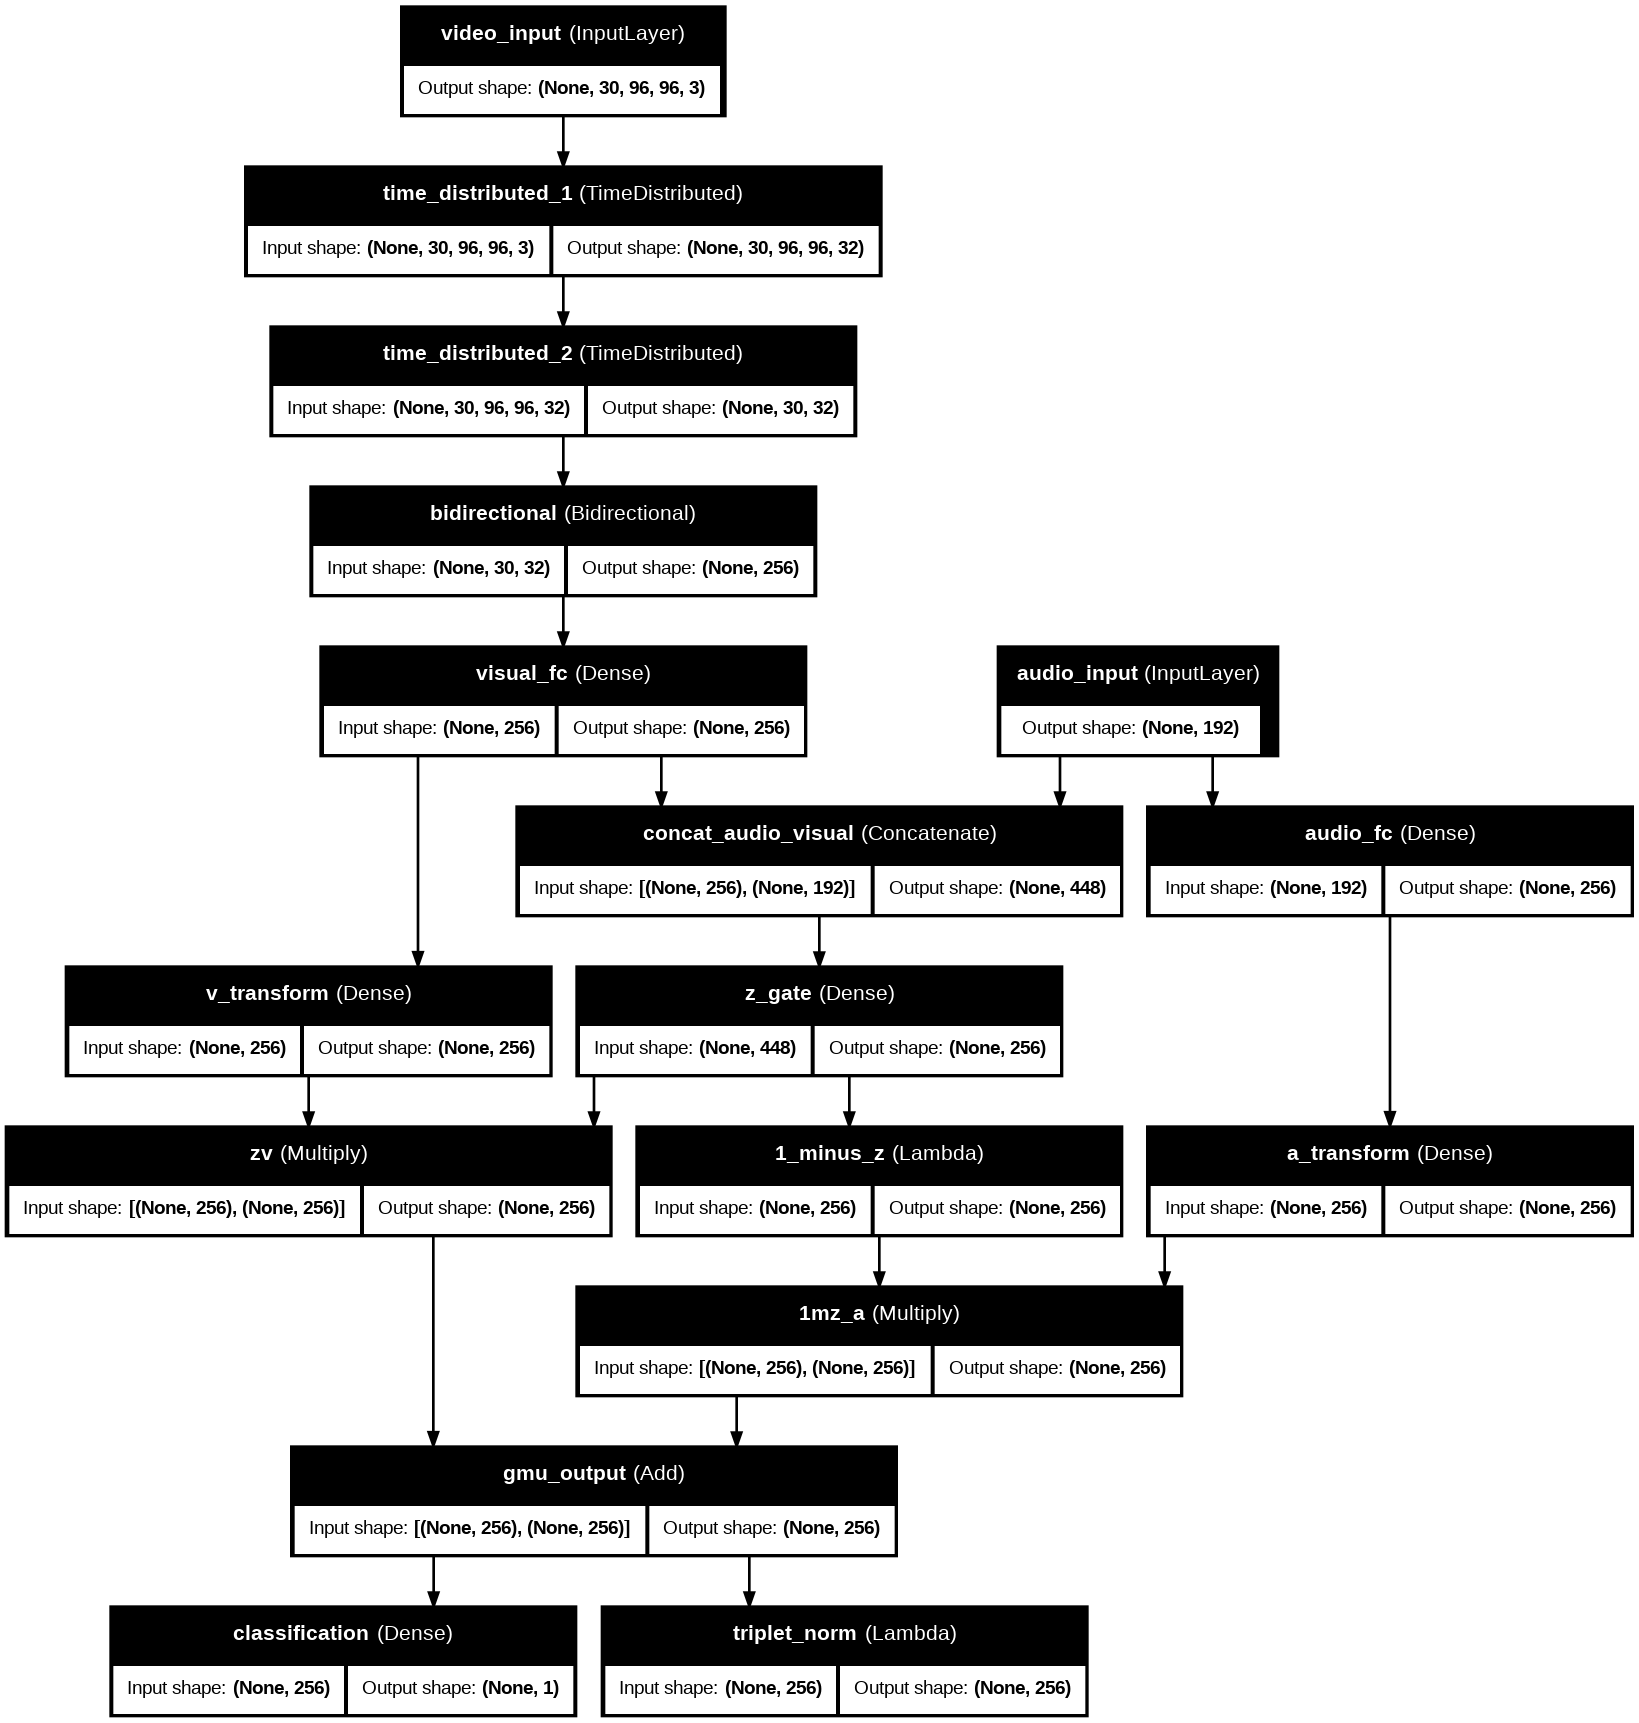

In [ ]:
from keras.models import Model
from keras.layers import (Input, Conv2D, TimeDistributed, GlobalAveragePooling2D,
                          Bidirectional, GRU, Dense, Concatenate, Lambda, Multiply, Add)
from keras.utils import plot_model
import tensorflow as tf

# --- Visual Stream (per-frame Conv2D + GRU) ---
video_input = Input(shape=(30, 96, 96, 3), name='video_input')
x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(video_input)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = Bidirectional(GRU(128))(x)
visual_embedding = Dense(256, activation='relu', name='visual_fc')(x)

# --- Audio Stream ---
audio_input = Input(shape=(192,), name='audio_input')
audio_proj = Dense(256, activation='relu', name='audio_fc')(audio_input)

# --- GMU Fusion ---
concat = Concatenate(name='concat_audio_visual')([visual_embedding, audio_input])
z = Dense(256, activation='sigmoid', name='z_gate')(concat)

v_trans = Dense(256, activation='tanh', name='v_transform')(visual_embedding)
a_trans = Dense(256, activation='tanh', name='a_transform')(audio_proj)

z_inv = Lambda(lambda x: 1.0 - x, name='1_minus_z')(z)
zv = Multiply(name='zv')([z, v_trans])
za = Multiply(name='1mz_a')([z_inv, a_trans])
fused = Add(name='gmu_output')([zv, za])

# --- Output Head ---
classification_output = Dense(1, activation='sigmoid', name='classification')(fused)
triplet_embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='triplet_norm')(fused)

model = Model(inputs=[video_input, audio_input], outputs=[classification_output, triplet_embedding])

# Save the model diagram
plot_model(model, show_shapes=True, show_layer_names=True, to_file="biovid_model.png", dpi=96)


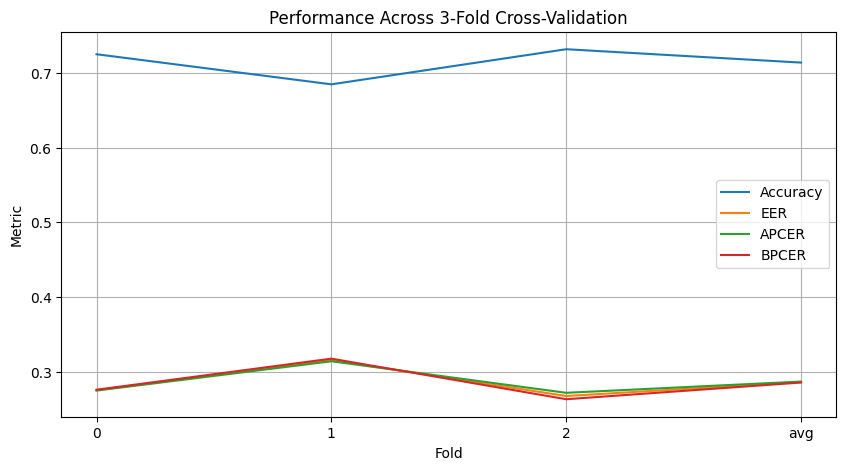

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/biovid_dual_auth/updated_pipeline/results/biovid_results_20250620_0738.csv")  # use your actual path

plt.figure(figsize=(10, 5))
plt.plot(df['fold'], df['accuracy'], label='Accuracy')
plt.plot(df['fold'], df['eer'], label='EER')
plt.plot(df['fold'], df['apcer'], label='APCER')
plt.plot(df['fold'], df['bpcer'], label='BPCER')
plt.xlabel("Fold")
plt.ylabel("Metric")
plt.title("Performance Across 3-Fold Cross-Validation")
plt.legend()
plt.grid()
plt.savefig("training_metrics_curve.png")
plt.show()
